In [1]:
# Cell 0: Install dependencies
!pip install transformers datasets evaluate seqeval accelerate wandb
!pip install pandas numpy matplotlib seaborn
!pip install sentencepiece sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.4 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=18d1e09c5e1d341c693537be5bba1bd7be7401f679f9460f16be23165cddd120
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 25.0 MB/s eta 0:00:0000:01


In [2]:
# Cell 1: Setup and imports

import torch
import numpy as np
import pandas as pd
from datasets import load_dataset, DatasetDict, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from evaluate import load
import wandb
import os
from sklearn.metrics import classification_report
import json

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)


2026-01-07 13:59:57.253644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767794397.409743      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767794397.453754      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767794397.813220      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767794397.813253      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767794397.813256      55 computation_placer.cc:177] computation placer alr

In [3]:
# Cell 2: Configuration
class TeacherConfig:
    MODEL_NAME = "xlm-roberta-large"
    DATASET_NAME = "wikiann"
    LANGUAGES = ["en", "de", "fr"]  # Start with 3 languages
    MAX_LENGTH = 128
    BATCH_SIZE = 16
    GRADIENT_ACCUMULATION_STEPS = 2
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 3
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01
    LABEL_NAMES = [
        "O",
        "B-PER", "I-PER",
        "B-ORG", "I-ORG",
        "B-LOC", "I-LOC"
    ]
    NUM_LABELS = 7
    OUTPUT_DIR = "./models/teacher"
    LOGGING_DIR = "./logs/teacher"

config = TeacherConfig()

In [4]:
# Cell 3: Initialize W&B for experiment tracking
wandb.init(
    project="multilingual-ner",
    name="teacher-model-training",
    mode="offline",  # <--- Add this line to go Offline
    config={
        "model": config.MODEL_NAME,
        "languages": config.LANGUAGES,
        "batch_size": config.BATCH_SIZE,
        "learning_rate": config.LEARNING_RATE,
        "epochs": config.NUM_EPOCHS
    }
)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [5]:
# Cell 4: Load and prepare multilingual dataset

def load_multilingual_dataset(languages, max_train_samples=20000):
    datasets_dict = {}
    
    # 1. Load individual datasets from Hugging Face
    for lang in languages:
        try:
            print(f"Loading {lang} dataset...")
            datasets_dict[lang] = load_dataset(config.DATASET_NAME, lang)
        except Exception as e:
            print(f"Error loading {lang}: {e}")
    
    train_list, val_list, test_list = [], [], []
    
    # 2. Calculate how many samples to take per language to be fair
    # This ensures an even distribution across your chosen languages
    samples_per_lang = max_train_samples // len(languages)
    eval_samples_per_lang = samples_per_lang // 4  # Keep validation smaller for speed

    for lang, ds in datasets_dict.items():
        # Shuffle and select a subset for each language to keep it representative
        train_sub = ds['train'].shuffle(seed=42).select(range(min(samples_per_lang, len(ds['train']))))
        val_sub = ds['validation'].shuffle(seed=42).select(range(min(eval_samples_per_lang, len(ds['validation']))))
        
        # Select a small portion of the test set for the specific language
        test_sub = ds['test'].shuffle(seed=42).select(range(min(500, len(ds['test']))))
        
        # Add 'language' column to ALL splits to avoid ValueError during tokenization (.map)
        train_list.append(train_sub.add_column("language", [lang] * len(train_sub)))
        val_list.append(val_sub.add_column("language", [lang] * len(val_sub)))
        test_list.append(test_sub.add_column("language", [lang] * len(test_sub)))
        
    # 3. Combine everything into a single DatasetDict
    # Using concatenate_datasets keeps the object as a Hugging Face Dataset (not a list)
    combined_dataset = DatasetDict({
        'train': concatenate_datasets(train_list).shuffle(seed=42),
        'validation': concatenate_datasets(val_list).shuffle(seed=42),
        'test': concatenate_datasets(test_list).shuffle(seed=42)
    })
    
    # Print statistics for verification
    print(f"\nCombined dataset sizes:")
    print(f"  Train: {len(combined_dataset['train'])}")
    print(f"  Validation: {len(combined_dataset['validation'])}")
    print(f"  Test: {len(combined_dataset['test'])}")
    
    return combined_dataset

# Run the loader
dataset = load_multilingual_dataset(config.LANGUAGES)

Loading en dataset...


README.md: 0.00B [00:00, ?B/s]

en/validation-00000-of-00001.parquet:   0%|          | 0.00/748k [00:00<?, ?B/s]

en/test-00000-of-00001.parquet:   0%|          | 0.00/748k [00:00<?, ?B/s]

en/train-00000-of-00001.parquet:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Loading de dataset...


de/validation-00000-of-00001.parquet:   0%|          | 0.00/835k [00:00<?, ?B/s]

de/test-00000-of-00001.parquet:   0%|          | 0.00/832k [00:00<?, ?B/s]

de/train-00000-of-00001.parquet:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Loading fr dataset...


fr/validation-00000-of-00001.parquet:   0%|          | 0.00/673k [00:00<?, ?B/s]

fr/test-00000-of-00001.parquet:   0%|          | 0.00/678k [00:00<?, ?B/s]

fr/train-00000-of-00001.parquet:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/6666 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/1666 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/500 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/6666 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/1666 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/500 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/6666 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/1666 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/500 [00:00<?, ? examples/s]


Combined dataset sizes:
  Train: 19998
  Validation: 4998
  Test: 1500


In [6]:
# Cell 5: Initialize tokenizer and model
print(f"Loading tokenizer: {config.MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

print(f"Loading model: {config.MODEL_NAME}")
model = AutoModelForTokenClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=config.NUM_LABELS,
    id2label={i: label for i, label in enumerate(config.LABEL_NAMES)},
    label2id={label: i for i, label in enumerate(config.LABEL_NAMES)},
    ignore_mismatched_sizes=True
)

Loading tokenizer: xlm-roberta-large


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Loading model: xlm-roberta-large


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Cell 6: Tokenization function with alignment
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=config.MAX_LENGTH,
        padding="max_length"
    )
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [8]:
# Cell 7: Preprocess dataset
print("Tokenizing dataset...")
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names
)

Tokenizing dataset...


Map:   0%|          | 0/19998 [00:00<?, ? examples/s]

Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [9]:
# Cell 8: Metrics computation
seqeval = load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    
    true_predictions = [
        [config.LABEL_NAMES[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [config.LABEL_NAMES[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = seqeval.compute(
        predictions=true_predictions,
        references=true_labels
    )
    
    # Log to wandb
    wandb.log({
        "eval_precision": results["overall_precision"],
        "eval_recall": results["overall_recall"],
        "eval_f1": results["overall_f1"],
        "eval_accuracy": results["overall_accuracy"]
    })
    
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

In [10]:
# Cell 9: Training arguments
training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=config.LEARNING_RATE,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.BATCH_SIZE * 2,
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=config.NUM_EPOCHS,
    weight_decay=config.WEIGHT_DECAY,
    warmup_ratio=config.WARMUP_RATIO,
    logging_dir=config.LOGGING_DIR,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="wandb",
    save_total_limit=2,
    fp16=True,                             # Explicitly set to True for Kaggle GPUs (T4/P100)
    group_by_length=True,                  # Batches sentences of similar length to reduce padding
    push_to_hub=False,
)


In [11]:
# Cell 10: Data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

In [12]:
# Cell 11: Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_55/1441693471.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
# Cell 12: Train the model
print("Starting training...")
train_result = trainer.train()

Starting training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.245600,0.213434,0.818143,0.840700,0.829268,0.937720
2,0.166400,0.192309,0.840847,0.857039,0.848866,0.944120
3,0.123000,0.187454,0.853886,0.868709,0.861234,0.948056


In [14]:
# Cell 13: Save model and metrics
trainer.save_model()
tokenizer.save_pretrained(config.OUTPUT_DIR)

# Save training metrics
metrics = train_result.metrics
metrics.update(trainer.evaluate())

with open(os.path.join(config.OUTPUT_DIR, "training_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print(f"Model saved to {config.OUTPUT_DIR}")
print(f"Training metrics: {metrics}")

Model saved to ./models/teacher
Training metrics: {'train_runtime': 2578.1083, 'train_samples_per_second': 23.271, 'train_steps_per_second': 0.727, 'total_flos': 1.3929447957815808e+16, 'train_loss': 0.2722141825358073, 'epoch': 3.0, 'eval_loss': 0.18615511059761047, 'eval_precision': 0.8538858617722971, 'eval_recall': 0.8687089715536105, 'eval_f1': 0.8612336394533227, 'eval_accuracy': 0.9480560251147065, 'eval_runtime': 60.6976, 'eval_samples_per_second': 82.343, 'eval_steps_per_second': 2.587}


In [15]:
# Cell 14: Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.evaluate(tokenized_dataset["test"])
print(f"Test results: {test_results}")


Evaluating on test set...
Test results: {'eval_loss': 0.18790274858474731, 'eval_precision': 0.844465203176086, 'eval_recall': 0.8605425987624941, 'eval_f1': 0.8524280999528524, 'eval_accuracy': 0.9450593519409689, 'eval_runtime': 18.2441, 'eval_samples_per_second': 82.218, 'eval_steps_per_second': 2.576, 'epoch': 3.0}


In [17]:
# Cell 15: Per-language evaluation
def evaluate_by_language(dataset, trainer, tokenizer):
    language_results = {}
    
    # Get the list of columns to remove from the train split
    # This prevents the ValueError because it looks at column names, not split names
    cols_to_remove = dataset["train"].column_names

    for lang in config.LANGUAGES:
        print(f"\nEvaluating on {lang}...")
        
        # 1. Filter the DatasetDict by language
        lang_dataset = dataset.filter(lambda x: x["language"] == lang)
        
        # 2. Map the tokenization
        # Use the specific column list we extracted above
        tokenized_lang_dataset = lang_dataset.map(
            tokenize_and_align_labels,
            batched=True,
            remove_columns=cols_to_remove
        )
        
        # 3. Evaluate using the 'test' split of the filtered data
        results = trainer.evaluate(tokenized_lang_dataset["test"])
        language_results[lang] = results
        
        print(f"{lang} results: {results}")
        
        # Log to wandb
        wandb.log({
            f"{lang}/f1": results["eval_f1"],
            f"{lang}/precision": results["eval_precision"],
            f"{lang}/recall": results["eval_recall"]
        })
    
    return language_results

# Uncomment to run per-language evaluation
lang_results = evaluate_by_language(dataset, trainer, tokenizer)
lang_results


Evaluating on en...


Map:   0%|          | 0/6666 [00:00<?, ? examples/s]

Map:   0%|          | 0/1666 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

en results: {'eval_loss': 0.22802604734897614, 'eval_precision': 0.8235294117647058, 'eval_recall': 0.8431372549019608, 'eval_f1': 0.8332179930795848, 'eval_accuracy': 0.9333819596401653, 'eval_runtime': 6.1106, 'eval_samples_per_second': 81.825, 'eval_steps_per_second': 2.618, 'epoch': 3.0}

Evaluating on de...


Filter:   0%|          | 0/19998 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4998 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6666 [00:00<?, ? examples/s]

Map:   0%|          | 0/1666 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

de results: {'eval_loss': 0.1435982584953308, 'eval_precision': 0.841248303934871, 'eval_recall': 0.8635097493036211, 'eval_f1': 0.8522336769759449, 'eval_accuracy': 0.9591836734693877, 'eval_runtime': 6.116, 'eval_samples_per_second': 81.752, 'eval_steps_per_second': 2.616, 'epoch': 3.0}

Evaluating on fr...


Filter:   0%|          | 0/19998 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4998 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6666 [00:00<?, ? examples/s]

Map:   0%|          | 0/1666 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

fr results: {'eval_loss': 0.19990099966526031, 'eval_precision': 0.8707280832095097, 'eval_recall': 0.8759342301943199, 'eval_f1': 0.8733233979135617, 'eval_accuracy': 0.9392123287671232, 'eval_runtime': 6.0813, 'eval_samples_per_second': 82.22, 'eval_steps_per_second': 2.631, 'epoch': 3.0}


{'en': {'eval_loss': 0.22802604734897614,
  'eval_precision': 0.8235294117647058,
  'eval_recall': 0.8431372549019608,
  'eval_f1': 0.8332179930795848,
  'eval_accuracy': 0.9333819596401653,
  'eval_runtime': 6.1106,
  'eval_samples_per_second': 81.825,
  'eval_steps_per_second': 2.618,
  'epoch': 3.0},
 'de': {'eval_loss': 0.1435982584953308,
  'eval_precision': 0.841248303934871,
  'eval_recall': 0.8635097493036211,
  'eval_f1': 0.8522336769759449,
  'eval_accuracy': 0.9591836734693877,
  'eval_runtime': 6.116,
  'eval_samples_per_second': 81.752,
  'eval_steps_per_second': 2.616,
  'epoch': 3.0},
 'fr': {'eval_loss': 0.19990099966526031,
  'eval_precision': 0.8707280832095097,
  'eval_recall': 0.8759342301943199,
  'eval_f1': 0.8733233979135617,
  'eval_accuracy': 0.9392123287671232,
  'eval_runtime': 6.0813,
  'eval_samples_per_second': 82.22,
  'eval_steps_per_second': 2.631,
  'epoch': 3.0}}

In [19]:
# Cell 16: Inference example (Corrected)
def predict_entities(text, model, tokenizer):
    """
    Perform NER inference on a single text
    """
    # 1. Tokenize (returns a BatchEncoding object)
    tokens = text.split()
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=config.MAX_LENGTH
    )
    
    # 2. EXTRACT WORD_IDS NOW while 'inputs' is still a BatchEncoding object
    word_ids = inputs.word_ids(batch_index=0)
    
    # 3. Move to device (this turns 'inputs' into a plain dict)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # 4. Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    predictions = torch.argmax(outputs.logits, dim=-1)[0].cpu().numpy()
    
    # 5. Align predictions with tokens
    # (word_ids is already defined from step 2)
    previous_word_idx = None
    predictions_aligned = []
    
    for idx, word_idx in enumerate(word_ids):
        if word_idx is not None and word_idx != previous_word_idx:
            predictions_aligned.append(predictions[idx])
        previous_word_idx = word_idx
        
    # ... (rest of your label conversion logic is fine)
    # Convert to labels
    entities = []
    current_entity = None
    current_start = None
    
    for i, (token, pred_idx) in enumerate(zip(tokens, predictions_aligned)):
        label = config.LABEL_NAMES[pred_idx]
        
        if label.startswith("B-"):
            if current_entity:
                entities.append({
                    "entity": " ".join(tokens[current_start:i]),
                    "label": current_entity,
                    "start": current_start,
                    "end": i
                })
            current_entity = label[2:]
            current_start = i
        elif label.startswith("I-") and current_entity == label[2:]:
            continue
        else:
            if current_entity:
                entities.append({
                    "entity": " ".join(tokens[current_start:i]),
                    "label": current_entity,
                    "start": current_start,
                    "end": i
                })
                current_entity = None
                current_start = None
    
    if current_entity:
        entities.append({
            "entity": " ".join(tokens[current_start:]),
            "label": current_entity,
            "start": current_start,
            "end": len(tokens)
        })
    
    return entities

# Test inference
test_text = "Apple Inc. is headquartered in Cupertino, California and was founded by Steve Jobs."
print(f"\nText: {test_text}")
entities = predict_entities(test_text, model, tokenizer)
print(f"Entities found: {entities}")


Text: Apple Inc. is headquartered in Cupertino, California and was founded by Steve Jobs.
Entities found: [{'entity': 'Apple Inc.', 'label': 'ORG', 'start': 0, 'end': 2}, {'entity': 'Cupertino, California', 'label': 'LOC', 'start': 5, 'end': 7}, {'entity': 'Steve Jobs.', 'label': 'PER', 'start': 11, 'end': 13}]


In [20]:
# Cell 17: Save model artifacts
def save_model_artifacts(model, tokenizer, config, output_dir):
    # Save model in different formats
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    
    # Save config
    config_dict = {
        "model_name": config.MODEL_NAME,
        "languages": config.LANGUAGES,
        "max_length": config.MAX_LENGTH,
        "label_names": config.LABEL_NAMES,
        "training_params": {
            "batch_size": config.BATCH_SIZE,
            "learning_rate": config.LEARNING_RATE,
            "epochs": config.NUM_EPOCHS
        }
    }
    
    with open(os.path.join(output_dir, "config.json"), "w") as f:
        json.dump(config_dict, f, indent=2)
    
    print(f"Model artifacts saved to {output_dir}")

save_model_artifacts(model, tokenizer, config, config.OUTPUT_DIR)

Model artifacts saved to ./models/teacher


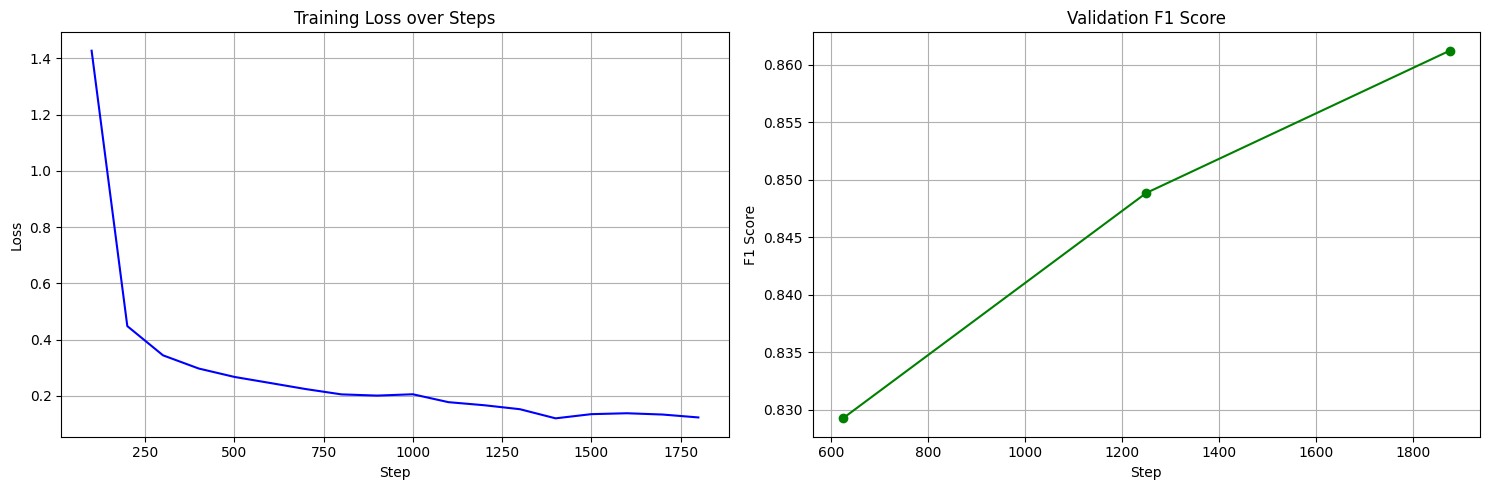

In [25]:
import json
import os
import matplotlib.pyplot as plt

def plot_training_metrics(state_file):
    # Load the trainer_state.json which contains the history
    with open(state_file, 'r') as f:
        state = json.load(f)
    
    history = state['log_history']
    
    # Extract values for plotting
    train_loss = [x['loss'] for x in history if 'loss' in x]
    train_steps = [x['step'] for x in history if 'loss' in x]
    
    eval_f1 = [x['eval_f1'] for x in history if 'eval_f1' in x]
    eval_steps = [x['step'] for x in history if 'eval_f1' in x]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Training Loss
    if train_loss:
        axes[0].plot(train_steps, train_loss, label='Training Loss', color='blue')
        axes[0].set_title('Training Loss over Steps')
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Loss')
        axes[0].grid(True)
    
    # Plot Validation F1
    if eval_f1:
        axes[1].plot(eval_steps, eval_f1, label='Eval F1', color='green', marker='o')
        axes[1].set_title('Validation F1 Score')
        axes[1].set_xlabel('Step')
        axes[1].set_ylabel('F1 Score')
        axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, "training_plots.png"))
    plt.show()

# Point this to the trainer_state.json in your output directory
plot_training_metrics('/kaggle/working/models/teacher/checkpoint-1875/trainer_state.json')

In [26]:
# Cell 19: Complete W&B run
wandb.finish()
print("\nTraining completed successfully!")

de/f1,▁
de/precision,▁
de/recall,▁
en/f1,▁
en/precision,▁
en/recall,▁
eval/accuracy,▂▄▅▅▄▁█▃
eval/f1,▁▄▆▆▅▂▅█
eval/loss,▇▅▅▅▅█▁▆
eval/precision,▁▄▆▆▅▂▄█
+16,...



Training completed successfully!


In [29]:
!# To remove the folder and all files inside (free up space)
!rm -rf /kaggle/working/models/teacher/checkpoint-1875

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
!rm -rf /kaggle/working/teacher_model_training_compressed.tar.xz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
!tar -cvJf /kaggle/working/teacher_model_training_compressed.tar.xz -C /kaggle/working . --exclude=teacher_model_training_compressed.tar.xz

./
./models/
./models/teacher/
./models/teacher/config.json
./models/teacher/training_metrics.json
./models/teacher/special_tokens_map.json
./models/teacher/tokenizer.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


./models/teacher/tokenizer_config.json
./models/teacher/training_plots.png
./models/teacher/model.safetensors
^C


# STUDENT

In [32]:
# notebooks/03_knowledge_distillation.ipynb

# Cell 1: Setup and imports
#!pip install transformers[torch] datasets accelerate
#!pip install torch --index-url https://download.pytorch.org/whl/cu118

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from transformers.trainer_utils import EvalPrediction
import os
import json
from typing import Optional, Dict, Any
import wandb

# Set seeds
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)


In [33]:
# Cell 2: Configuration for distillation
class DistillationConfig:
    TEACHER_MODEL = "./models/teacher"  # Path to trained teacher
    STUDENT_MODEL = "xlm-roberta-base"  # Smaller model
    DATASET_NAME = "wikiann"
    LANGUAGES = ["en", "de", "fr"]
    MAX_LENGTH = 128
    BATCH_SIZE = 32  # Larger batch for distillation
    GRADIENT_ACCUMULATION_STEPS = 1
    LEARNING_RATE = 3e-5
    NUM_EPOCHS = 5
    TEMPERATURE = 2.0  # Temperature for softmax
    ALPHA = 0.5  # Weight for distillation loss vs hard labels
    OUTPUT_DIR = "./models/student_distilled"
    LABEL_NAMES = [
        "O",
        "B-PER", "I-PER",
        "B-ORG", "I-ORG",
        "B-LOC", "I-LOC"
    ]
    NUM_LABELS = 7

config = DistillationConfig()

In [34]:
# Cell 3: Initialize W&B
wandb.init(
    project="multilingual-ner",
    name="knowledge-distillation",
    mode="offline",              # offline mode
    config={
        "teacher": config.TEACHER_MODEL,
        "student": config.STUDENT_MODEL,
        "temperature": config.TEMPERATURE,
        "alpha": config.ALPHA,
        "batch_size": config.BATCH_SIZE,
        "learning_rate": config.LEARNING_RATE,
        "epochs": config.NUM_EPOCHS
    }
)

In [39]:
# Cell 4: Load teacher model
from transformers import AutoModelForTokenClassification, AutoTokenizer, XLMRobertaConfig

print("Loading teacher model...")

# 1. Manually create the architecture config
# This tells the library: "Even if the JSON is custom, treat this as an XLM-RoBERTa model with 7 labels"
manual_config = XLMRobertaConfig.from_pretrained(
    "xlm-roberta-large", 
    num_labels=len(config.LABEL_NAMES),
    id2label={i: label for i, label in enumerate(config.LABEL_NAMES)},
    label2id={label: i for i, label in enumerate(config.LABEL_NAMES)}
)

# 2. Load the tokenizer from the local folder
teacher_tokenizer = AutoTokenizer.from_pretrained(config.TEACHER_MODEL)

# 3. Load the model using the manual_config + your saved weights
# This maps your model.safetensors onto the XLM-R Large architecture
teacher_model = AutoModelForTokenClassification.from_pretrained(
    config.TEACHER_MODEL,
    config=manual_config
)

teacher_model.eval()
print("Teacher model loaded successfully!")

Loading teacher model...
Teacher model loaded successfully!


In [40]:
# Cell 5: Load student model
print("Loading student model...")
student_tokenizer = AutoTokenizer.from_pretrained(config.STUDENT_MODEL)
student_model = AutoModelForTokenClassification.from_pretrained(
    config.STUDENT_MODEL,
    num_labels=config.NUM_LABELS,
    id2label={i: label for i, label in enumerate(config.LABEL_NAMES)},
    label2id={label: i for i, label in enumerate(config.LABEL_NAMES)}
)

Loading student model...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Cell 4: Load and prepare multilingual dataset

def load_multilingual_dataset(languages, max_train_samples=20000):
    datasets_dict = {}
    
    # 1. Load individual datasets from Hugging Face
    for lang in languages:
        try:
            print(f"Loading {lang} dataset...")
            datasets_dict[lang] = load_dataset(config.DATASET_NAME, lang)
        except Exception as e:
            print(f"Error loading {lang}: {e}")
    
    train_list, val_list, test_list = [], [], []
    
    # 2. Calculate how many samples to take per language to be fair
    # This ensures an even distribution across your chosen languages
    samples_per_lang = max_train_samples // len(languages)
    eval_samples_per_lang = samples_per_lang // 4  # Keep validation smaller for speed

    for lang, ds in datasets_dict.items():
        # Shuffle and select a subset for each language to keep it representative
        train_sub = ds['train'].shuffle(seed=42).select(range(min(samples_per_lang, len(ds['train']))))
        val_sub = ds['validation'].shuffle(seed=42).select(range(min(eval_samples_per_lang, len(ds['validation']))))
        
        # Select a small portion of the test set for the specific language
        test_sub = ds['test'].shuffle(seed=42).select(range(min(500, len(ds['test']))))
        
        # Add 'language' column to ALL splits to avoid ValueError during tokenization (.map)
        train_list.append(train_sub.add_column("language", [lang] * len(train_sub)))
        val_list.append(val_sub.add_column("language", [lang] * len(val_sub)))
        test_list.append(test_sub.add_column("language", [lang] * len(test_sub)))
        
    # 3. Combine everything into a single DatasetDict
    # Using concatenate_datasets keeps the object as a Hugging Face Dataset (not a list)
    combined_dataset = DatasetDict({
        'train': concatenate_datasets(train_list).shuffle(seed=42),
        'validation': concatenate_datasets(val_list).shuffle(seed=42),
        'test': concatenate_datasets(test_list).shuffle(seed=42)
    })
    
    # Print statistics for verification
    print(f"\nCombined dataset sizes:")
    print(f"  Train: {len(combined_dataset['train'])}")
    print(f"  Validation: {len(combined_dataset['validation'])}")
    print(f"  Test: {len(combined_dataset['test'])}")
    
    return combined_dataset

# Run the loader
dataset = load_multilingual_dataset(config.LANGUAGES)

Loading en dataset...
Loading de dataset...
Loading fr dataset...

Combined dataset sizes:
  Train: 19998
  Validation: 4998
  Test: 1500


In [42]:
# Cell 7: Tokenization function
def tokenize_and_align_labels(examples, tokenizer):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=config.MAX_LENGTH,
        padding="max_length"
    )
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [51]:
# Cell 8: Custom distillation trainer
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, temperature=2.0, alpha=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.temperature = temperature
        self.alpha = alpha
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')
        
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Updated signature to include num_items_in_batch for transformers compatibility
        """
        labels = inputs.pop("labels")
        
        # Get student outputs
        outputs = model(**inputs)
        student_logits = outputs.logits
        
        # Get teacher outputs (no gradient)
        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits
        
        # Compute distillation loss (KL divergence)
        # We divide by T^2 as per Hintons paper to keep gradients consistent
        distillation_loss = self.kl_loss(
            F.log_softmax(student_logits / self.temperature, dim=-1),
            F.softmax(teacher_logits / self.temperature, dim=-1)
        ) * (self.temperature ** 2)
        
        # Compute hard label loss (standard CrossEntropy)
        loss_fct = nn.CrossEntropyLoss()
        hard_label_loss = loss_fct(
            student_logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )
        
        # Combined loss: α knowledge from teacher + (1-α) ground truth
        loss = self.alpha * distillation_loss + (1 - self.alpha) * hard_label_loss
        
        # Note: In newer Trainer versions, don't manually log to wandb inside compute_loss
        # as it runs every step and can slow down training. 
        # The Trainer handles logging via its own logging_steps logic.

        return (loss, outputs) if return_outputs else loss

In [44]:
# Cell 9: Preprocess dataset for student
print("Tokenizing dataset for student...")
tokenized_dataset = dataset.map(
    lambda x: tokenize_and_align_labels(x, student_tokenizer),
    batched=True,
    remove_columns=dataset["train"].column_names
)

Tokenizing dataset for student...


Map:   0%|          | 0/19998 [00:00<?, ? examples/s]

Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [46]:
# Cell 10: Training arguments for distillation
training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=config.LEARNING_RATE,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.BATCH_SIZE * 2,
    num_train_epochs=config.NUM_EPOCHS,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_dir="./logs/distillation",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="wandb",
    save_total_limit=2,
    fp16=True,
    push_to_hub=False,
)


In [47]:
# Cell 11: Compute metrics function
from evaluate import load
seqeval = load("seqeval")

def compute_metrics(p: EvalPrediction):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    
    true_predictions = [
        [config.LABEL_NAMES[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [config.LABEL_NAMES[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = seqeval.compute(
        predictions=true_predictions,
        references=true_labels
    )
    
    wandb.log({
        "eval_precision": results["overall_precision"],
        "eval_recall": results["overall_recall"],
        "eval_f1": results["overall_f1"],
        "eval_accuracy": results["overall_accuracy"]
    })
    
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

In [48]:
# Cell 12: Data collator
data_collator = DataCollatorForTokenClassification(student_tokenizer)

In [52]:
# Cell 13: Create distillation trainer
trainer = DistillationTrainer(
    model=student_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=student_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    teacher_model=teacher_model,
    temperature=config.TEMPERATURE,
    alpha=config.ALPHA
)


/tmp/ipykernel_55/3841941174.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [54]:
# Move teacher to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)

# Verify student is also there
student_model.to(device)

print(f"Teacher device: {teacher_model.device}")
print(f"Student device: {student_model.device}")

Teacher device: cuda:0
Student device: cuda:0


In [55]:
# Cell 14: Train the student model
print("Starting knowledge distillation...")
train_result = trainer.train()

Starting knowledge distillation...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,14.171600,10.333790,0.775250,0.790518,0.782810,0.917629
2,9.365900,8.382884,0.796489,0.814150,0.805223,0.930717
3,7.052600,6.768042,0.819398,0.830635,0.824978,0.935330
4,5.242900,6.313475,0.822241,0.838074,0.830082,0.938083
5,4.239300,6.183316,0.818932,0.839241,0.828963,0.937841


In [56]:
# Cell 15: Save distilled model
trainer.save_model()
student_tokenizer.save_pretrained(config.OUTPUT_DIR)

# Save distillation metrics
metrics = train_result.metrics
metrics.update(trainer.evaluate())

with open(os.path.join(config.OUTPUT_DIR, "distillation_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print(f"Distilled model saved to {config.OUTPUT_DIR}")


Distilled model saved to ./models/student_distilled


In [58]:
# Cell 16: Compare teacher vs student
def compare_models(teacher_model, student_model, tokenizer, dataset, num_samples=100):
    """
    Compare predictions between teacher and student
    """
    import random
    import torch
    import numpy as np
    
    # Get random samples from validation set
    samples = random.sample(list(dataset["validation"]), num_samples)
    
    teacher_correct = 0
    student_correct = 0
    agreement = 0
    total_tokens = 0
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    teacher_model.to(device)
    student_model.to(device)
    
    # Set both models to evaluation mode
    teacher_model.eval()
    student_model.eval()
    
    for sample in samples:
        tokens = sample["tokens"]
        true_labels = sample["ner_tags"]
        
        # 1. Tokenize (returns a BatchEncoding object)
        # We need this object to access .word_ids()
        inputs_obj = tokenizer(
            tokens,
            is_split_into_words=True,
            return_tensors="pt",
            truncation=True,
            max_length=config.MAX_LENGTH,
            padding="max_length"
        )
        
        # 2. Extract word_ids IMMEDIATELY
        # This is the fix for the AttributeError
        word_ids = inputs_obj.word_ids(batch_index=0)
        
        # 3. Move tensors to device (converts inputs_obj to a standard dict)
        inputs = {k: v.to(device) for k, v in inputs_obj.items()}
        
        # 4. Get predictions
        with torch.no_grad():
            teacher_outputs = teacher_model(**inputs)
            student_outputs = student_model(**inputs)
        
        # Move logits to CPU and get the max arg
        teacher_preds = torch.argmax(teacher_outputs.logits, dim=-1)[0].cpu().numpy()
        student_preds = torch.argmax(student_outputs.logits, dim=-1)[0].cpu().numpy()
        
        # 5. Align predictions with words
        previous_word_idx = None
        teacher_aligned = []
        student_aligned = []
        
        for idx, word_idx in enumerate(word_ids):
            # Only look at the first token of each word (standard NER evaluation)
            if word_idx is not None and word_idx != previous_word_idx:
                if word_idx < len(true_labels):  # Safety check for bounds
                    teacher_aligned.append(teacher_preds[idx])
                    student_aligned.append(student_preds[idx])
            previous_word_idx = word_idx
        
        # 6. Compare aligned predictions with Ground Truth
        # Ensure we only compare if lengths match exactly
        if len(teacher_aligned) == len(true_labels):
            teacher_correct += sum(1 for t, tl in zip(teacher_aligned, true_labels) if t == tl)
            student_correct += sum(1 for s, tl in zip(student_aligned, true_labels) if s == tl)
            agreement += sum(1 for t, s in zip(teacher_aligned, student_aligned) if t == s)
            total_tokens += len(true_labels)
    
    # Avoid division by zero
    total_tokens = max(total_tokens, 1)
    
    return {
        "teacher_accuracy": teacher_correct / total_tokens,
        "student_accuracy": student_correct / total_tokens,
        "prediction_agreement": agreement / total_tokens,
        "total_tokens_evaluated": total_tokens
    }

# Run comparison
print("Running comparison between Teacher and Student...")
comparison = compare_models(teacher_model, student_model, student_tokenizer, dataset)

print(f"\nModel comparison results ({comparison['total_tokens_evaluated']} tokens):")
print(f"  Teacher accuracy:      {comparison['teacher_accuracy']:.4f}")
print(f"  Student accuracy:      {comparison['student_accuracy']:.4f}")
print(f"  Prediction agreement: {comparison['prediction_agreement']:.4f}")

Running comparison between Teacher and Student...

Model comparison results (989 tokens):
  Teacher accuracy:      0.9616
  Student accuracy:      0.9505
  Prediction agreement: 0.9767


In [59]:
# Cell 17: Compute model sizes
def get_model_size(model, model_name=""):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

teacher_size = get_model_size(teacher_model, "Teacher")
student_size = get_model_size(student_model, "Student")

print(f"\nModel sizes:")
print(f"  Teacher model: {teacher_size:.2f} MB")
print(f"  Student model: {student_size:.2f} MB")
print(f"  Compression ratio: {teacher_size/student_size:.2f}x")

# Log to wandb
wandb.log({
    "teacher_size_mb": teacher_size,
    "student_size_mb": student_size,
    "compression_ratio": teacher_size/student_size,
    "teacher_accuracy": comparison['teacher_accuracy'],
    "student_accuracy": comparison['student_accuracy']
})


Model sizes:
  Teacher model: 2131.84 MB
  Student model: 1058.43 MB
  Compression ratio: 2.01x


In [60]:
# Cell 18: Save comparison results
comparison_results = {
    "model_sizes": {
        "teacher_mb": teacher_size,
        "student_mb": student_size,
        "compression_ratio": teacher_size/student_size
    },
    "performance": comparison,
    "distillation_params": {
        "temperature": config.TEMPERATURE,
        "alpha": config.ALPHA
    }
}

with open(os.path.join(config.OUTPUT_DIR, "comparison_results.json"), "w") as f:
    json.dump(comparison_results, f, indent=2)

Plots saved to ./models/student_distilled/distillation_plots.png


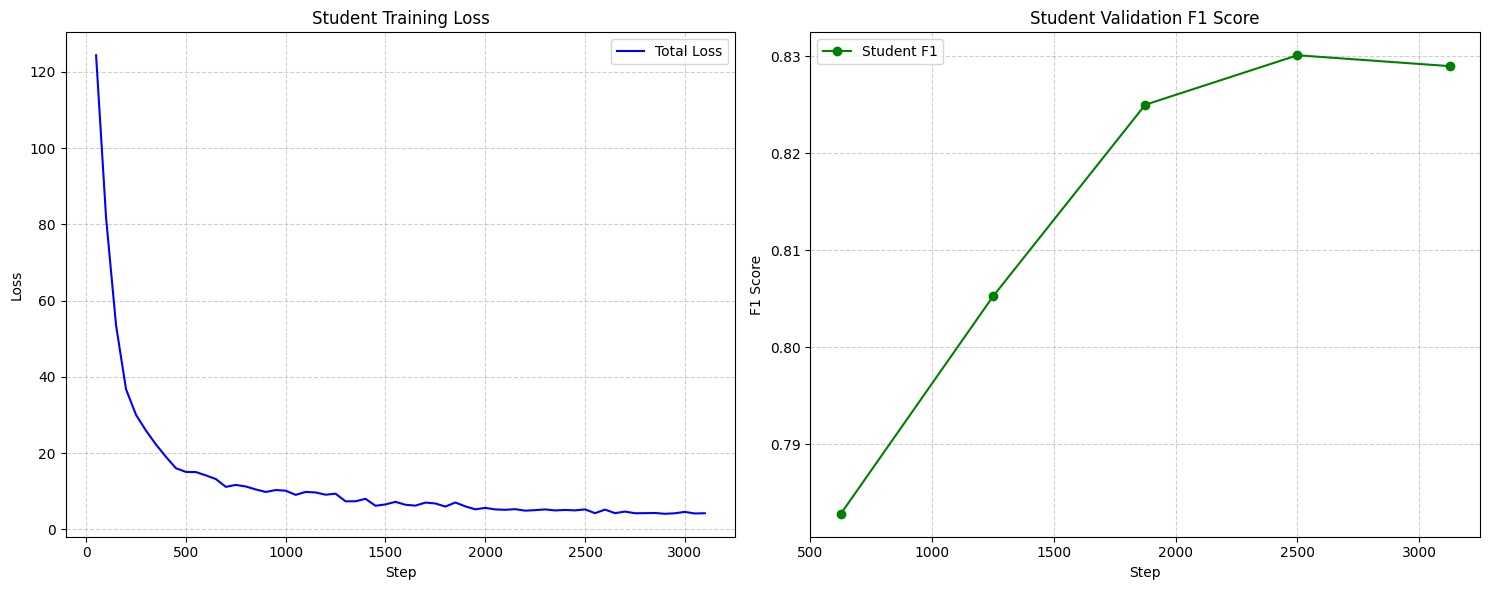

In [64]:
# Cell 19: Visualize knowledge transfer
def plot_knowledge_transfer(state_file):
    """
    Parses trainer_state.json to visualize the distillation process
    """
    # Load training logs
    try:
        with open(state_file, 'r') as f:
            state = json.load(f)
        
        # Access the history list
        history = state.get('log_history', [])
        
        # Extract data for plotting
        steps = []
        total_loss = []
        distill_loss = []
        hard_loss = []
        
        eval_steps = []
        eval_f1 = []

        for entry in history:
            # Training logs usually have 'loss'
            if 'loss' in entry:
                steps.append(entry['step'])
                total_loss.append(entry['loss'])
                # These might be present if you used custom logging in compute_loss
                if 'distillation_loss' in entry:
                    distill_loss.append(entry['distillation_loss'])
                if 'hard_label_loss' in entry:
                    hard_loss.append(entry['hard_label_loss'])
            
            # Evaluation logs usually have 'eval_f1' or 'eval_loss'
            if 'eval_f1' in entry:
                eval_steps.append(entry['step'])
                eval_f1.append(entry['eval_f1'])

        # Create visualization
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Total Training Loss
        if total_loss:
            axes[0].plot(steps, total_loss, label='Total Loss', color='blue')
            axes[0].set_title('Student Training Loss')
            axes[0].set_xlabel('Step')
            axes[0].set_ylabel('Loss')
            axes[0].grid(True, linestyle='--', alpha=0.6)
            
            # Add component losses if they exist
            if distill_loss:
                axes[0].plot(steps, distill_loss, label='Distill Component', alpha=0.7)
            if hard_loss:
                axes[0].plot(steps, hard_loss, label='Hard Label Component', alpha=0.7)
            axes[0].legend()
        
        # Plot 2: Validation F1 Score
        if eval_f1:
            axes[1].plot(eval_steps, eval_f1, marker='o', color='green', label='Student F1')
            axes[1].set_title('Student Validation F1 Score')
            axes[1].set_xlabel('Step')
            axes[1].set_ylabel('F1 Score')
            axes[1].grid(True, linestyle='--', alpha=0.6)
            axes[1].legend()

        plt.tight_layout()
        
        # Ensure output directory exists before saving
        os.makedirs(config.OUTPUT_DIR, exist_ok=True)
        save_path = os.path.join(config.OUTPUT_DIR, "distillation_plots.png")
        plt.savefig(save_path)
        print(f"Plots saved to {save_path}")
        plt.show()
        
    except FileNotFoundError:
        print(f"Error: The file {state_file} was not found.")
    except Exception as e:
        print(f"Could not generate plots: {e}")

# Call the function with your specific checkpoint path
plot_knowledge_transfer('/kaggle/working/models/student_distilled/checkpoint-3125/trainer_state.json')

In [65]:
# Cell 20: Test inference with distilled model
def test_distilled_inference(model, tokenizer, text):
    print(f"\nTesting inference with distilled model:")
    print(f"Text: {text}")
    
    # 1. Tokenize as a list of words
    tokens = text.split()
    inputs_obj = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=config.MAX_LENGTH
    )
    
    # 2. Extract word_ids BEFORE moving to device
    # This avoids the AttributeError: 'dict' object has no attribute 'word_ids'
    word_ids = inputs_obj.word_ids(batch_index=0)
    
    # 3. Move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs_obj.items()}
    
    # 4. Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    predictions = torch.argmax(outputs.logits, dim=-1)[0].cpu().numpy()
    
    # 5. Align predictions with original tokens
    previous_word_idx = None
    predictions_aligned = []
    
    for idx, word_idx in enumerate(word_ids):
        # We only care about the first sub-token of each word
        if word_idx is not None and word_idx != previous_word_idx:
            predictions_aligned.append(predictions[idx])
        previous_word_idx = word_idx
    
    # 6. Format output and extract entities
    entities = []
    current_entity = None
    current_start = None
    
    # Iterate through tokens and their aligned predicted label indices
    for i, (token, pred_idx) in enumerate(zip(tokens, predictions_aligned)):
        label = config.LABEL_NAMES[pred_idx]
        
        # Start of a new entity
        if label.startswith("B-"):
            # If we were already tracking an entity, save it before starting new one
            if current_entity:
                entities.append(f"{current_entity}: {' '.join(tokens[current_start:i])}")
            current_entity = label[2:] # Strip the "B-"
            current_start = i
            
        # Inside an entity (I-tag)
        elif label.startswith("I-"):
            # If it's a continuation of the same type, we just keep going
            # If we aren't tracking or type changed, treat it as a new entity (safety)
            if not current_entity or current_entity != label[2:]:
                if current_entity:
                    entities.append(f"{current_entity}: {' '.join(tokens[current_start:i])}")
                current_entity = label[2:]
                current_start = i
                
        # Outside an entity (O-tag)
        else:
            if current_entity:
                entities.append(f"{current_entity}: {' '.join(tokens[current_start:i])}")
                current_entity = None
                current_start = None
    
    # Add final entity if the sentence ended while tracking
    if current_entity:
        entities.append(f"{current_entity}: {' '.join(tokens[current_start:])}")
    
    print(f"Entities found: {entities}")
    return entities

# Test
test_texts = [
    "Apple was founded by Steve Jobs in Cupertino.",
    "Berlin is the capital of Germany.",
    "Google is a technology company based in Mountain View."
]

# Ensure student_model and tokenizer are loaded and ready
for text in test_texts:
    test_distilled_inference(student_model, student_tokenizer, text)


Testing inference with distilled model:
Text: Apple was founded by Steve Jobs in Cupertino.
Entities found: ['ORG: Apple', 'PER: Steve Jobs', 'LOC: Cupertino.']

Testing inference with distilled model:
Text: Berlin is the capital of Germany.
Entities found: ['LOC: Berlin', 'LOC: Germany.']

Testing inference with distilled model:
Text: Google is a technology company based in Mountain View.
Entities found: ['ORG: Google', 'LOC: Mountain View.']


In [66]:
# Cell 21: Finish W&B run
wandb.finish()
print("\nKnowledge distillation completed successfully!")

compression_ratio,▁
eval/accuracy,▁▅▇███
eval/f1,▁▄▇███
eval/loss,█▅▂▁▁▁
eval/precision,▁▄████
eval/recall,▁▄▇███
eval/runtime,█▄▁▄▂▄
eval/samples_per_second,▁▅█▅▇▄
eval/steps_per_second,▁█████
eval_accuracy,▁▅▇███
+12,...



Knowledge distillation completed successfully!


In [67]:
!rm -rf /kaggle/working/models/student_distilled/checkpoint-2500

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# notebooks/04_hyperparameter_tuning.ipynb

In [68]:
# Cell 1: Setup and imports
!pip install optuna transformers[torch] datasets accelerate
!pip install plotly kaleido  # For visualization

import optuna
from optuna.trial import TrialState
import torch
import numpy as np
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
import json
import os
import warnings
warnings.filterwarnings('ignore')
from functools import partial
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set seeds
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [90]:
# Cell 2: Configuration
class OptunaConfig:
    STUDENT_MODEL = "xlm-roberta-base"
    TEACHER_MODEL = "./models/teacher"  # For distillation
    DATASET_NAME = "wikiann"
    LANGUAGES = ["en", "de"]  # Use subset for faster tuning
    MAX_LENGTH = 128
    NUM_LABELS = 7
    OUTPUT_DIR = "./models/optuna_tuned"
    N_TRIALS = 10  # Number of Optuna trials
    TIMEOUT = 3600  # 1 hour timeout
    LABEL_NAMES = [
        "O",
        "B-PER", "I-PER",
        "B-ORG", "I-ORG",
        "B-LOC", "I-LOC"
    ]

config = OptunaConfig()

In [70]:
# Cell 3: Load and prepare dataset
def prepare_dataset():
    datasets = {}
    
    for lang in config.LANGUAGES:
        try:
            print(f"Loading {lang} dataset...")
            dataset = load_dataset(config.DATASET_NAME, lang)
            datasets[lang] = dataset
        except Exception as e:
            print(f"Error loading {lang}: {e}")
    
    # Combine and split for tuning (small subset)
    combined_train = []
    combined_val = []
    
    for lang, dataset in datasets.items():
        # Take smaller subset for faster tuning
        train_subset = dataset['train'].select(range(2000))
        val_subset = dataset['validation'].select(range(500))
        
        combined_train.extend(train_subset)
        combined_val.extend(val_subset)
    
    return DatasetDict({
        'train': combined_train,
        'validation': combined_val
    })

dataset = prepare_dataset()
print(f"Training samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")

Loading en dataset...
Loading de dataset...
Training samples: 4000
Validation samples: 1000


In [77]:
from datasets import Dataset, DatasetDict

# --- RE-CONVERSION STEP ---
# This converts your lists back into Hugging Face Dataset objects
if isinstance(dataset["train"], list):
    print("Detected list format. Re-converting to Hugging Face Datasets...")
    dataset = DatasetDict({
        split: Dataset.from_list(dataset[split]) 
        for split in dataset.keys()
    })

# Now the rest of your code will work perfectly
tokenizer = AutoTokenizer.from_pretrained(config.STUDENT_MODEL)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=config.MAX_LENGTH,
        padding="max_length"
    )
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Identify columns to remove (now .column_names will work!)
columns_to_remove = dataset["train"].column_names

# Map the function
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=columns_to_remove
)

print("\nSuccess! Dataset tokenized and aligned.")

Detected list format. Re-converting to Hugging Face Datasets...


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


Success! Dataset tokenized and aligned.


In [95]:
# Cell 5: Define objective function for Optuna
import torch
import gc
import os
import shutil
import wandb
from transformers import AutoModelForTokenClassification, TrainingArguments, DataCollatorForTokenClassification

def objective(trial, tokenized_dataset):
    # 1. Initialize wandb in OFFLINE mode for this specific trial
    # This prevents the "must call wandb.init()" error by giving the trainer a local run
    run = wandb.init(
        project="ner_distillation_optuna",
        name=f"trial_{trial.number}",
        mode="offline",
        reinit=True,
        anonymous="allow"
    )

    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    num_train_epochs = trial.suggest_int("num_train_epochs", 2, 4) # Reduced for tuning speed
    
    # Distillation specific parameters
    temperature = trial.suggest_float("temperature", 1.0, 5.0)
    alpha = trial.suggest_float("alpha", 0.1, 0.9)
    
    # Initialize Student Model
    # FIX: Added explicit id2label/label2id mapping to ensure F1 isn't 0.0
    model = AutoModelForTokenClassification.from_pretrained(
        config.STUDENT_MODEL,
        num_labels=config.NUM_LABELS,
        id2label={i: label for i, label in enumerate(config.LABEL_NAMES)},
        label2id={label: i for i, label in enumerate(config.LABEL_NAMES)}
    )
    
    # Training arguments
    trial_tmp_dir = f"./tmp_trial_{trial.number}"
    training_args = TrainingArguments(
        output_dir=trial_tmp_dir,
        eval_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        logging_steps=50,
        report_to="none",          # Disable automatic cloud logging
        skip_memory_metrics=True,   # Helps prevent extra logging calls
        save_strategy="no",         # FIX: Don't save weights to save disk space
        fp16=torch.cuda.is_available(),
        # This is required for Optuna pruning to work
        disable_tqdm=True 
    )
    
    # USE YOUR DistillationTrainer HERE
    trainer = DistillationTrainer(
        model=model,
        teacher_model=teacher_model, # Ensure teacher_model is global or passed in
        temperature=temperature,
        alpha=alpha,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer),
        compute_metrics=compute_metrics, # Use the function you defined
    )
    
    try:
        trainer.train()
        eval_results = trainer.evaluate()
        
        # FIX: Ensure we use .get() to handle potential missing keys safely
        score = eval_results.get("eval_f1", 0.0)
        
        # CLEANUP: Finish wandb run
        run.finish()
        
        # CLEANUP VRAM (Crucial for Optuna)
        del model
        del trainer
        gc.collect()
        torch.cuda.empty_cache()

        # CLEANUP DISK: Delete trial folder and local wandb logs to prevent 20GB limit crash
        shutil.rmtree(trial_tmp_dir, ignore_errors=True)
        if os.path.exists("./wandb"):
            shutil.rmtree("./wandb", ignore_errors=True)
        
        return score
        
    except Exception as e:
        # Cleanup even if it fails
        if 'run' in locals():
            run.finish(exit_code=1)
        del model
        gc.collect()
        torch.cuda.empty_cache()
        shutil.rmtree(trial_tmp_dir, ignore_errors=True)
        print(f"Trial {trial.number} failed: {e}")
        return 0.0

In [96]:
# Cell 6: Create Optuna study
import os
import optuna

# 1. Ensure the output directory exists
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

# 2. Define the storage URL (using absolute path is safer in Kaggle)
storage_path = f"sqlite:///{os.path.abspath(config.OUTPUT_DIR)}/optuna.db"
print(f"Database will be saved at: {storage_path}")

# 3. Create the study
def create_study():
    study = optuna.create_study(
        direction="maximize",
        study_name="multilingual_ner_distillation",
        storage=storage_path,
        load_if_exists=True,
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=10,
            interval_steps=1
        )
    )
    return study

study = create_study()

[I 2026-01-07 18:18:12,113] Using an existing study with name 'multilingual_ner_distillation' instead of creating a new one.


Database will be saved at: sqlite:////kaggle/working/models/optuna_tuned/optuna.db


In [102]:
# Cell 7: Run optimization
print(f"Starting Optuna optimization with {config.N_TRIALS} trials...")

# Create partial function for objective
objective_partial = partial(objective, tokenized_dataset=tokenized_dataset)

study.optimize(
    objective_partial,
    n_trials=config.N_TRIALS,
    timeout=config.TIMEOUT,
    show_progress_bar=True
)

Starting Optuna optimization with 10 trials...


  0%|          | 0/10 [00:00<?, ?it/s]

eval_accuracy,▁
eval_f1,▁
eval_precision,▁
eval_recall,▁
eval_accuracy,0.73147
eval_f1,0.32751
eval_precision,0.3146
eval_recall,0.34152


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 40.9999, 'grad_norm': 1243.584228515625, 'learning_rate': 1.0885374913252196e-05, 'epoch': 0.4}
{'loss': 21.8792, 'grad_norm': 235.21066284179688, 'learning_rate': 9.215838883612288e-06, 'epoch': 0.8}
{'eval_loss': 14.627320289611816, 'eval_precision': 0.21875, 'eval_recall': 0.046875, 'eval_f1': 0.07720588235294118, 'eval_accuracy': 0.6621171770972037, 'eval_runtime': 17.0032, 'eval_samples_per_second': 58.813, 'eval_steps_per_second': 7.352, 'epoch': 1.0}
{'loss': 16.5289, 'grad_norm': 187.8052520751953, 'learning_rate': 7.546302853972381e-06, 'epoch': 1.2}
{'loss': 12.6802, 'grad_norm': 409.6534423828125, 'learning_rate': 5.876766824332473e-06, 'epoch': 1.6}
{'loss': 11.1215, 'grad_norm': 437.83831787109375, 'learning_rate': 4.207230794692566e-06, 'epoch': 2.0}
{'eval_loss': 8.585430145263672, 'eval_precision': 0.5945945945945946, 'eval_recall': 0.5892857142857143, 'eval_f1': 0.5919282511210763, 'eval_accuracy': 0.7795162006213937, 'eval_runtime': 17.0069, 'eval_samples_per

eval_accuracy,▁███
eval_f1,▁▇██
eval_precision,▁▇██
eval_recall,▁███
eval_accuracy,0.78662
eval_f1,0.63166
eval_precision,0.63236
eval_recall,0.63095


[I 2026-01-07 18:31:21,260] Trial 26 finished with value: 0.631657355679702 and parameters: {'learning_rate': 1.2521520222299304e-05, 'batch_size': 32, 'num_train_epochs': 3, 'temperature': 1.7608725922213273, 'alpha': 0.20448198842908563}. Best is trial 26 with value: 0.631657355679702.


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 26.4911, 'grad_norm': 141.0808868408203, 'learning_rate': 2.0422284882461512e-05, 'epoch': 0.4}
{'loss': 10.4027, 'grad_norm': 205.85720825195312, 'learning_rate': 1.729003259987539e-05, 'epoch': 0.8}
{'eval_loss': 5.9945573806762695, 'eval_precision': 0.4955264969029594, 'eval_recall': 0.5357142857142857, 'eval_f1': 0.5148373257061137, 'eval_accuracy': 0.7729693741677763, 'eval_runtime': 17.0141, 'eval_samples_per_second': 58.775, 'eval_steps_per_second': 7.347, 'epoch': 1.0}
{'loss': 6.7275, 'grad_norm': 144.6412353515625, 'learning_rate': 1.4157780317289271e-05, 'epoch': 1.2}
{'loss': 5.4868, 'grad_norm': 114.36744689941406, 'learning_rate': 1.1025528034703148e-05, 'epoch': 1.6}
{'loss': 5.013, 'grad_norm': 535.359619140625, 'learning_rate': 7.893275752117028e-06, 'epoch': 2.0}
{'eval_loss': 3.8753435611724854, 'eval_precision': 0.6562731997030438, 'eval_recall': 0.6577380952380952, 'eval_f1': 0.6570048309178744, 'eval_accuracy': 0.8196848646249445, 'eval_runtime': 16.9959,

eval_accuracy,▁▅██
eval_f1,▁▇██
eval_precision,▁▇██
eval_recall,▁▇██
eval_accuracy,0.85919
eval_f1,0.68755
eval_precision,0.68909
eval_recall,0.68601


[I 2026-01-07 18:37:17,518] Trial 27 finished with value: 0.6875466070096943 and parameters: {'learning_rate': 2.3491892119395914e-05, 'batch_size': 32, 'num_train_epochs': 3, 'temperature': 1.1300696007500195, 'alpha': 0.19537325061160385}. Best is trial 27 with value: 0.6875466070096943.


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 48.3234, 'grad_norm': 197.7684326171875, 'learning_rate': 1.0717442627396396e-05, 'epoch': 0.4}
{'loss': 24.8315, 'grad_norm': 291.3287353515625, 'learning_rate': 9.073663083317194e-06, 'epoch': 0.8}
{'eval_loss': 17.048328399658203, 'eval_precision': 0.20229007633587787, 'eval_recall': 0.03943452380952381, 'eval_f1': 0.0660024906600249, 'eval_accuracy': 0.6532401242787395, 'eval_runtime': 16.9625, 'eval_samples_per_second': 58.954, 'eval_steps_per_second': 7.369, 'epoch': 1.0}
{'loss': 18.7788, 'grad_norm': 187.36630249023438, 'learning_rate': 7.429883539237994e-06, 'epoch': 1.2}
{'loss': 13.9335, 'grad_norm': 226.0090789794922, 'learning_rate': 5.786103995158791e-06, 'epoch': 1.6}
{'loss': 12.0049, 'grad_norm': 358.4893798828125, 'learning_rate': 4.142324451079589e-06, 'epoch': 2.0}
{'eval_loss': 9.516107559204102, 'eval_precision': 0.5289139633286318, 'eval_recall': 0.5580357142857143, 'eval_f1': 0.5430847212165099, 'eval_accuracy': 0.7789613848202397, 'eval_runtime': 16.97

eval_accuracy,▁███
eval_f1,▁▇██
eval_precision,▁▇██
eval_recall,▁▇██
eval_accuracy,0.78584
eval_f1,0.59513
eval_precision,0.58991
eval_recall,0.60045


[I 2026-01-07 18:43:14,066] Trial 28 finished with value: 0.5951327433628318 and parameters: {'learning_rate': 1.2328346580594015e-05, 'batch_size': 32, 'num_train_epochs': 3, 'temperature': 2.2784146544121437, 'alpha': 0.18896629451692906}. Best is trial 27 with value: 0.6875466070096943.


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 30.6083, 'grad_norm': 481.4521789550781, 'learning_rate': 2.1132666883530803e-05, 'epoch': 0.4}
{'loss': 12.7802, 'grad_norm': 194.8902587890625, 'learning_rate': 1.789146030630215e-05, 'epoch': 0.8}
{'eval_loss': 7.756994724273682, 'eval_precision': 0.4694996572995202, 'eval_recall': 0.5096726190476191, 'eval_f1': 0.4887620406707099, 'eval_accuracy': 0.7688637372392366, 'eval_runtime': 16.9835, 'eval_samples_per_second': 58.881, 'eval_steps_per_second': 7.36, 'epoch': 1.0}
{'loss': 8.4104, 'grad_norm': 206.4488983154297, 'learning_rate': 1.4650253729073502e-05, 'epoch': 1.2}
{'loss': 7.1932, 'grad_norm': 199.0181884765625, 'learning_rate': 1.1409047151844851e-05, 'epoch': 1.6}
{'loss': 6.3554, 'grad_norm': 299.0316162109375, 'learning_rate': 8.1678405746162e-06, 'epoch': 2.0}
{'eval_loss': 5.1164326667785645, 'eval_precision': 0.6605705925384052, 'eval_recall': 0.671875, 'eval_f1': 0.6661748432312798, 'eval_accuracy': 0.8020417221482468, 'eval_runtime': 16.9501, 'eval_samples

eval_accuracy,▁▃██
eval_f1,▁▇██
eval_precision,▁▇██
eval_recall,▁▇██
eval_accuracy,0.86185
eval_f1,0.69069
eval_precision,0.69697
eval_recall,0.68452


[I 2026-01-07 18:49:10,020] Trial 29 finished with value: 0.6906906906906907 and parameters: {'learning_rate': 2.430904932921488e-05, 'batch_size': 32, 'num_train_epochs': 3, 'temperature': 1.489960090219177, 'alpha': 0.1769077338286403}. Best is trial 29 with value: 0.6906906906906907.


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 26.8862, 'grad_norm': 119.54466247558594, 'learning_rate': 2.1179435032548774e-05, 'epoch': 0.4}
{'loss': 10.6632, 'grad_norm': 188.08860778808594, 'learning_rate': 1.7931055426329635e-05, 'epoch': 0.8}
{'eval_loss': 6.322642803192139, 'eval_precision': 0.5195493704440026, 'eval_recall': 0.5833333333333334, 'eval_f1': 0.5495969155275149, 'eval_accuracy': 0.7776298268974701, 'eval_runtime': 16.9773, 'eval_samples_per_second': 58.902, 'eval_steps_per_second': 7.363, 'epoch': 1.0}
{'loss': 7.212, 'grad_norm': 117.23246002197266, 'learning_rate': 1.46826758201105e-05, 'epoch': 1.2}
{'loss': 5.7752, 'grad_norm': 198.23023986816406, 'learning_rate': 1.1434296213891363e-05, 'epoch': 1.6}
{'loss': 5.2527, 'grad_norm': 207.98794555664062, 'learning_rate': 8.185916607672225e-06, 'epoch': 2.0}
{'eval_loss': 4.326265811920166, 'eval_precision': 0.6561151079136691, 'eval_recall': 0.6785714285714286, 'eval_f1': 0.6671543525969276, 'eval_accuracy': 0.8511984021304927, 'eval_runtime': 16.9509

eval_accuracy,▁▇██
eval_f1,▁▇██
eval_precision,▁▇██
eval_recall,▁▇██
eval_accuracy,0.87106
eval_f1,0.69572
eval_precision,0.69062
eval_recall,0.70089


[I 2026-01-07 18:55:05,953] Trial 30 finished with value: 0.6957163958641064 and parameters: {'learning_rate': 2.4362847046643528e-05, 'batch_size': 32, 'num_train_epochs': 3, 'temperature': 1.5167020975930399, 'alpha': 0.15446500498432433}. Best is trial 30 with value: 0.6957163958641064.


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 20.4513, 'grad_norm': 168.60934448242188, 'learning_rate': 2.1627685982781038e-05, 'epoch': 0.4}
{'loss': 8.3113, 'grad_norm': 190.53866577148438, 'learning_rate': 1.8310556230820757e-05, 'epoch': 0.8}
{'eval_loss': 4.995506763458252, 'eval_precision': 0.43550531914893614, 'eval_recall': 0.48735119047619047, 'eval_f1': 0.4599719101123595, 'eval_accuracy': 0.7671992898357746, 'eval_runtime': 16.9797, 'eval_samples_per_second': 58.894, 'eval_steps_per_second': 7.362, 'epoch': 1.0}
{'loss': 5.455, 'grad_norm': 107.02422332763672, 'learning_rate': 1.4993426478860475e-05, 'epoch': 1.2}
{'loss': 4.3262, 'grad_norm': 109.27323150634766, 'learning_rate': 1.1676296726900192e-05, 'epoch': 1.6}
{'loss': 3.9067, 'grad_norm': 256.5289001464844, 'learning_rate': 8.359166974939911e-06, 'epoch': 2.0}
{'eval_loss': 3.3655638694763184, 'eval_precision': 0.6199859254046446, 'eval_recall': 0.6555059523809523, 'eval_f1': 0.637251356238698, 'eval_accuracy': 0.8500887705281847, 'eval_runtime': 16.98

eval_accuracy,▁▆██
eval_f1,▁▇██
eval_precision,▁▆██
eval_recall,▁▇██
eval_accuracy,0.87905
eval_f1,0.68343
eval_precision,0.67941
eval_recall,0.6875


[I 2026-01-07 19:01:02,049] Trial 31 finished with value: 0.6834319526627219 and parameters: {'learning_rate': 2.4878473139702115e-05, 'batch_size': 32, 'num_train_epochs': 3, 'temperature': 1.0454373763130327, 'alpha': 0.16997711293111242}. Best is trial 30 with value: 0.6957163958641064.


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 17.2989, 'grad_norm': 74.47254943847656, 'learning_rate': 2.394529183368379e-05, 'epoch': 0.4}
{'loss': 7.8294, 'grad_norm': 129.23287963867188, 'learning_rate': 2.02727010616464e-05, 'epoch': 0.8}
{'eval_loss': 4.480818271636963, 'eval_precision': 0.4455891822279459, 'eval_recall': 0.5148809523809523, 'eval_f1': 0.4777355885398688, 'eval_accuracy': 0.7650909897913892, 'eval_runtime': 16.9836, 'eval_samples_per_second': 58.88, 'eval_steps_per_second': 7.36, 'epoch': 1.0}
{'loss': 5.1105, 'grad_norm': 109.77853393554688, 'learning_rate': 1.660011028960901e-05, 'epoch': 1.2}
{'loss': 4.0142, 'grad_norm': 87.73076629638672, 'learning_rate': 1.2927519517571617e-05, 'epoch': 1.6}
{'loss': 3.7465, 'grad_norm': 213.06777954101562, 'learning_rate': 9.254928745534226e-06, 'epoch': 2.0}
{'eval_loss': 2.916012763977051, 'eval_precision': 0.64375, 'eval_recall': 0.6897321428571429, 'eval_f1': 0.665948275862069, 'eval_accuracy': 0.8634043497558811, 'eval_runtime': 16.9625, 'eval_samples_pe

eval_accuracy,▁▆██
eval_f1,▁▇██
eval_precision,▁▆██
eval_recall,▁▇██
eval_accuracy,0.89325
eval_f1,0.71098
eval_precision,0.70196
eval_recall,0.72024


[I 2026-01-07 19:06:57,954] Trial 32 finished with value: 0.7109805361733381 and parameters: {'learning_rate': 2.7544430790280434e-05, 'batch_size': 32, 'num_train_epochs': 3, 'temperature': 1.4266961307368469, 'alpha': 0.10459523676415396}. Best is trial 32 with value: 0.7109805361733381.


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 16.982, 'grad_norm': 92.34516143798828, 'learning_rate': 2.3735440958676395e-05, 'epoch': 0.4}
{'loss': 8.0262, 'grad_norm': 115.52241516113281, 'learning_rate': 2.0095035903664678e-05, 'epoch': 0.8}
{'eval_loss': 4.7022786140441895, 'eval_precision': 0.3902439024390244, 'eval_recall': 0.44047619047619047, 'eval_f1': 0.4138413142257952, 'eval_accuracy': 0.7586551264980027, 'eval_runtime': 16.9858, 'eval_samples_per_second': 58.873, 'eval_steps_per_second': 7.359, 'epoch': 1.0}
{'loss': 5.3743, 'grad_norm': 84.32349395751953, 'learning_rate': 1.6454630848652964e-05, 'epoch': 1.2}
{'loss': 4.0982, 'grad_norm': 118.26274871826172, 'learning_rate': 1.2814225793641245e-05, 'epoch': 1.6}
{'loss': 3.6937, 'grad_norm': 323.6283264160156, 'learning_rate': 9.173820738629528e-06, 'epoch': 2.0}
{'eval_loss': 2.914287805557251, 'eval_precision': 0.6291486291486291, 'eval_recall': 0.6488095238095238, 'eval_f1': 0.6388278388278389, 'eval_accuracy': 0.8711717709720372, 'eval_runtime': 16.9911

eval_accuracy,▁▇██
eval_f1,▁▇██
eval_precision,▁▇██
eval_recall,▁▆██
eval_accuracy,0.90146
eval_f1,0.69613
eval_precision,0.68364
eval_recall,0.70908


[I 2026-01-07 19:12:54,056] Trial 33 finished with value: 0.6961285609934258 and parameters: {'learning_rate': 2.730303791258788e-05, 'batch_size': 32, 'num_train_epochs': 3, 'temperature': 1.3735746334392411, 'alpha': 0.10527320522644483}. Best is trial 32 with value: 0.7109805361733381.


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 17.0061, 'grad_norm': 93.5002212524414, 'learning_rate': 2.4028933599921175e-05, 'epoch': 0.4}
{'loss': 7.9321, 'grad_norm': 142.9009246826172, 'learning_rate': 2.0343514336129583e-05, 'epoch': 0.8}
{'eval_loss': 4.714171886444092, 'eval_precision': 0.3743654822335025, 'eval_recall': 0.43898809523809523, 'eval_f1': 0.40410958904109584, 'eval_accuracy': 0.7548823790501553, 'eval_runtime': 16.9919, 'eval_samples_per_second': 58.852, 'eval_steps_per_second': 7.356, 'epoch': 1.0}
{'loss': 5.581, 'grad_norm': 74.70557403564453, 'learning_rate': 1.6658095072337995e-05, 'epoch': 1.2}
{'loss': 4.3193, 'grad_norm': 175.72760009765625, 'learning_rate': 1.2972675808546401e-05, 'epoch': 1.6}
{'loss': 3.9578, 'grad_norm': 158.7412872314453, 'learning_rate': 9.287256544754811e-06, 'epoch': 2.0}
{'eval_loss': 2.953604221343994, 'eval_precision': 0.5964539007092199, 'eval_recall': 0.6257440476190477, 'eval_f1': 0.6107480029048657, 'eval_accuracy': 0.8405459387483355, 'eval_runtime': 16.9656, 

eval_accuracy,▁▅██
eval_f1,▁▆██
eval_precision,▁▆██
eval_recall,▁▆██
eval_accuracy,0.89314
eval_f1,0.68152
eval_precision,0.6693
eval_recall,0.6942


[I 2026-01-07 19:18:50,082] Trial 34 finished with value: 0.6815193571950329 and parameters: {'learning_rate': 2.7640644478436936e-05, 'batch_size': 32, 'num_train_epochs': 3, 'temperature': 1.4157773455842484, 'alpha': 0.102343123590297}. Best is trial 32 with value: 0.7109805361733381.


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 27.587, 'grad_norm': 167.64247131347656, 'learning_rate': 1.8970697796412147e-05, 'epoch': 0.4}
{'loss': 11.4097, 'grad_norm': 181.44503784179688, 'learning_rate': 1.6061081569968568e-05, 'epoch': 0.8}
{'eval_loss': 6.669497489929199, 'eval_precision': 0.4759679572763685, 'eval_recall': 0.5305059523809523, 'eval_f1': 0.501759324419423, 'eval_accuracy': 0.772525521526853, 'eval_runtime': 16.9586, 'eval_samples_per_second': 58.967, 'eval_steps_per_second': 7.371, 'epoch': 1.0}
{'loss': 7.5087, 'grad_norm': 129.43927001953125, 'learning_rate': 1.3151465343524986e-05, 'epoch': 1.2}
{'loss': 6.2013, 'grad_norm': 193.95480346679688, 'learning_rate': 1.0241849117081405e-05, 'epoch': 1.6}
{'loss': 5.7674, 'grad_norm': 527.5787353515625, 'learning_rate': 7.332232890637825e-06, 'epoch': 2.0}
{'eval_loss': 4.487786769866943, 'eval_precision': 0.6533333333333333, 'eval_recall': 0.65625, 'eval_f1': 0.6547884187082404, 'eval_accuracy': 0.8311140701287173, 'eval_runtime': 16.9467, 'eval_samp

eval_accuracy,▁▅██
eval_f1,▁▇██
eval_precision,▁▇██
eval_recall,▁▇██
eval_accuracy,0.86374
eval_f1,0.68525
eval_precision,0.68448
eval_recall,0.68601


[I 2026-01-07 19:24:45,982] Trial 35 finished with value: 0.6852471200297288 and parameters: {'learning_rate': 2.1822121698326857e-05, 'batch_size': 32, 'num_train_epochs': 3, 'temperature': 1.55594908790464, 'alpha': 0.152019819127799}. Best is trial 32 with value: 0.7109805361733381.


In [103]:
# Cell 8: Display optimization results
print("Optimization completed!")
print(f"Number of finished trials: {len(study.trials)}")

print("\nBest trial:")
trial = study.best_trial

print(f"  Value (F1 Score): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Optimization completed!
Number of finished trials: 36

Best trial:
  Value (F1 Score): 0.7110
  Params: 
    alpha: 0.10459523676415396
    batch_size: 32
    learning_rate: 2.7544430790280434e-05
    num_train_epochs: 3
    temperature: 1.4266961307368469


In [104]:
# Cell 9: Save best parameters
best_params = {
    "best_value": trial.value,
    "params": trial.params,
    "datetime": str(np.datetime64('now'))
}

os.makedirs(config.OUTPUT_DIR, exist_ok=True)
with open(os.path.join(config.OUTPUT_DIR, "best_params.json"), "w") as f:
    json.dump(best_params, f, indent=2)

print(f"\nBest parameters saved to {config.OUTPUT_DIR}/best_params.json")


Best parameters saved to ./models/optuna_tuned/best_params.json


In [106]:
!pip install -U kaleido

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [110]:
# Cell 10: Visualization 1 - Optimization History
import plotly.io as pio

def plot_optimization_history(study):
    # Set the renderer to work specifically in Kaggle/Colab environments
    pio.renderers.default = "notebook_connected" 
    
    fig = optuna.visualization.plot_optimization_history(study)
    fig.update_layout(
        title="Optimization History",
        xaxis_title="Trial",
        yaxis_title="F1 Score",
        template="plotly_white", # Force a clean theme
        width=900,
        height=500
    )
    
    # Use 'iframe' if 'notebook_connected' still shows white
    fig.show(renderer="iframe") 

plot_optimization_history(study)

In [111]:
# Cell 11: Visualization 2 - Parameter Importances
import plotly.io as pio
import optuna

def plot_param_importances(study):
    # 1. Set renderer to fix the "White Screen" issue in Kaggle
    pio.renderers.default = "notebook_connected"
    
    try:
        # 2. Use a different evaluator to avoid the "array element with a sequence" error
        # MeanDecreaseImpurity is more stable than the default fANOVA
        evaluator = optuna.importance.MeanDecreaseImpurityImportanceEvaluator()
        
        fig = optuna.visualization.plot_param_importances(study, evaluator=evaluator)
        
        fig.update_layout(
            title="Parameter Importances (Mean Decrease Impurity)",
            template="plotly_white",
            width=800,
            height=500
        )
        
        # 3. Use iframe renderer for reliable display in Kaggle
        fig.show(renderer="iframe")
        
    except Exception as e:
        print(f"Could not plot importance: {e}")
        print("This often happens if there are too few successful trials (score > 0).")
        print("Current successful trials:", len([t for t in study.trials if t.state.name == 'COMPLETE' and t.value > 0]))

plot_param_importances(study)

In [113]:
# Cell 12: Visualization 3 - Parallel Coordinate Plot
import plotly.io as pio

def plot_parallel_coordinate(study):
    # Set the renderer for Kaggle compatibility
    pio.renderers.default = "notebook_connected"
    
    # Check which parameters actually exist in the study to avoid ValueErrors
    # This automatically finds whatever you suggested (alpha, temperature, etc.)
    existing_params = list(study.best_params.keys())
    
    fig = optuna.visualization.plot_parallel_coordinate(
        study,
        params=existing_params
    )
    
    fig.update_layout(
        title="Hyperparameter Interactions (Parallel Coordinate)",
        template="plotly_white",
        width=1100,
        height=600
    )
    
    # Save image commented out unless Kaleido is fixed
    # fig.write_image(os.path.join(config.OUTPUT_DIR, "parallel_coordinate.png"))
    
    # Show using iframe to prevent the "White Screen" issue
    fig.show(renderer="iframe")

plot_parallel_coordinate(study)

In [116]:
# Cell 13: Visualization 4 - Slice Plot
import plotly.io as pio
import os

def plot_slice_plot(study):
    # Set the renderer for Kaggle compatibility
    pio.renderers.default = "notebook_connected"
    
    # Automatically get parameters that actually exist in the study
    # This prevents "Parameter X does not exist" errors
    existing_params = list(study.best_params.keys())
    
    fig = optuna.visualization.plot_slice(
        study,
        params=existing_params
    )
    
    fig.update_layout(
        title="Slice Plot (Parameter Relationships with F1)",
        template="plotly_white",
        width=1200, # Increased width to give each slice more room
        height=600
    )
    
    # Commented out to prevent the Kaleido/Image export error
    # if not os.path.exists(config.OUTPUT_DIR):
    #     os.makedirs(config.OUTPUT_DIR)
    # fig.write_image(os.path.join(config.OUTPUT_DIR, "slice_plot.png"))
    
    # Show using iframe renderer to ensure it displays in Kaggle
    fig.show(renderer="iframe")

plot_slice_plot(study)

In [117]:
# Cell 14: Create interactive dashboard
import pandas as pd
import plotly.express as px
import plotly.io as pio
from optuna.trial import TrialState
import os

def create_interactive_dashboard(study):
    # Set the renderer for Kaggle compatibility
    pio.renderers.default = "notebook_connected"
    
    # 1. Get trial data
    trials = study.trials
    
    # 2. Identify parameters that were actually used in the study
    # This prevents the script from crashing if 'weight_decay' or others are missing
    all_params = set()
    for t in trials:
        if t.state == TrialState.COMPLETE:
            all_params.update(t.params.keys())
    param_names = list(all_params)
    
    # 3. Create DataFrame for plotting
    data = []
    for trial in trials:
        if trial.state == TrialState.COMPLETE:
            # We want to handle cases where f1_score might be None
            score = trial.value if trial.value is not None else 0.0
            row = {"trial": trial.number, "f1_score": score}
            for param in param_names:
                row[param] = trial.params.get(param, None)
            data.append(row)
    
    if not data:
        print("No completed trials found to plot.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    # 4. Create interactive scatter matrix
    # Using Plotly Express (px)
    fig = px.scatter_matrix(
        df,
        dimensions=param_names,
        color="f1_score",
        symbol="f1_score", # Adds variation to points
        title="Hyperparameter Relationships (Scatter Matrix)",
        labels={col: col.replace('_', ' ') for col in df.columns}, # Clean up axis labels
        width=1200,
        height=800,
        color_continuous_scale=px.colors.sequential.Viridis
    )
    
    # Improve readability by reducing marker size and hiding diagonal labels
    fig.update_traces(diagonal_visible=False, marker=dict(size=5))
    
    # Commented out to prevent the Kaleido error
    # fig.write_image(os.path.join(config.OUTPUT_DIR, "scatter_matrix.png"))
    
    # Use iframe renderer for reliable display
    fig.show(renderer="iframe")
    
    return df

df_trials = create_interactive_dashboard(study)

In [118]:
# Cell 15: Train final model with best parameters
import json
import os
import torch
import numpy as np
from datasets import Dataset, DatasetDict, load_dataset
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification

def train_final_model(best_trial, full_dataset=True):
    print("\nTraining final model with best parameters...")
    
    # Extract params from the trial object
    params = best_trial.params
    
    # Load/Combine dataset logic
    if full_dataset:
        print("Loading full multilingual dataset...")
        combined_data = {'train': [], 'validation': []}
        for lang in ["en", "de", "fr", "es"]:
            try:
                ds = load_dataset(config.DATASET_NAME, lang)
                combined_data['train'].extend(ds['train'])
                combined_data['validation'].extend(ds['validation'])
            except Exception as e:
                print(f"Could not load {lang}: {e}")
                continue
        
        # Convert lists back to Hugging Face Datasets
        final_dataset = DatasetDict({
            'train': Dataset.from_list(combined_data['train']),
            'validation': Dataset.from_list(combined_data['validation'])
        })
    else:
        # Use the tokenized_dataset already in memory
        final_dataset = dataset 

    # Tokenize (using the same function from Cell 2)
    tokenized_final = final_dataset.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=final_dataset["train"].column_names
    )
    
    # Initialize model with correct label mappings
    model = AutoModelForTokenClassification.from_pretrained(
        config.STUDENT_MODEL,
        num_labels=config.NUM_LABELS,
        id2label={i: label for i, label in enumerate(config.LABEL_NAMES)},
        label2id={label: i for i, label in enumerate(config.LABEL_NAMES)}
    )
    
    # Training arguments with best params + safety defaults
    training_args = TrainingArguments(
        output_dir=os.path.join(config.OUTPUT_DIR, "final_model"),
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=params["learning_rate"],
        per_device_train_batch_size=params["batch_size"],
        per_device_eval_batch_size=params["batch_size"] * 2,
        num_train_epochs=params["num_train_epochs"],
        weight_decay=params.get("weight_decay", 0.01), # Default if not tuned
        warmup_ratio=params.get("warmup_ratio", 0.1),  # Default if not tuned
        logging_dir=os.path.join(config.OUTPUT_DIR, "logs_final"),
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        report_to="none",
        save_total_limit=1,
        fp16=torch.cuda.is_available(),
    )
    
    # Metrics
    from evaluate import load
    seqeval = load("seqeval")
    
    def compute_metrics(p):
        predictions, labels = p
        predictions = np.argmax(predictions, axis=2)
        true_predictions = [
            [config.LABEL_NAMES[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [config.LABEL_NAMES[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        results = seqeval.compute(predictions=true_predictions, references=true_labels)
        return {
            "f1": results["overall_f1"],
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "accuracy": results["overall_accuracy"]
        }
    
    # IMPORTANT: Use DistillationTrainer for the final run to keep the benefits!
    trainer = DistillationTrainer(
        model=model,
        teacher_model=teacher_model,
        temperature=params["temperature"],
        alpha=params["alpha"],
        args=training_args,
        train_dataset=tokenized_final["train"],
        eval_dataset=tokenized_final["validation"],
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer),
        compute_metrics=compute_metrics,
    )
    
    # Train and Evaluate
    trainer.train()
    final_eval = trainer.evaluate()
    
    # Save everything
    os.makedirs(os.path.join(config.OUTPUT_DIR, "final_model"), exist_ok=True)
    trainer.save_model()
    tokenizer.save_pretrained(os.path.join(config.OUTPUT_DIR, "final_model"))
    
    # Save metrics JSON
    with open(os.path.join(config.OUTPUT_DIR, "final_model", "training_metrics.json"), "w") as f:
        json.dump(final_eval, f, indent=2)
    
    print(f"✅ Final model saved with F1: {final_eval['eval_f1']:.4f}")
    return model, trainer, final_eval

# --- EXECUTION ---
# Pass the best trial from your study
final_model, final_trainer, final_metrics = train_final_model(study.best_trial, full_dataset=False)


Training final model with best parameters...


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,8.227400,4.788662,0.429593,0.413343,0.447173,0.765202
2,3.598700,2.836839,0.658617,0.647948,0.669643,0.884376
3,2.520300,2.318077,0.717724,0.703863,0.732143,0.910786


✅ Final model saved with F1: 0.7177


In [119]:
# Cell 16: Analyze hyperparameter relationships
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import os

def analyze_hyperparameter_relationships(df_trials):
    # Set the renderer for Kaggle compatibility
    pio.renderers.default = "notebook_connected"
    
    # 1. Prepare data - Exclude 'trial' number from correlation as it's just an index
    # We only want to see how hyperparameters correlate with f1_score
    numeric_cols = df_trials.select_dtypes(include=[np.number]).columns
    cols_to_corr = [col for col in numeric_cols if col != 'trial']
    corr_matrix = df_trials[cols_to_corr].corr()
    
    # 2. Create correlation heatmap
    fig = go.Figure(data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale='RdBu',
        zmin=-1, zmax=1, # Correlations are always between -1 and 1
        zmid=0,
        text=corr_matrix.round(2).values,
        texttemplate='%{text}',
        textfont={"size": 12}
    ))
    
    fig.update_layout(
        title="Hyperparameter & F1 Score Correlation Matrix",
        width=700,
        height=600,
        template="plotly_white"
    )
    
    # Commented out to prevent Kaleido error
    # fig.write_image(os.path.join(config.OUTPUT_DIR, "correlation_matrix.png"))
    
    # Show using iframe for Kaggle
    fig.show(renderer="iframe")
    
    # 3. Analyze best performing regions
    print("\n" + "="*30)
    print("TOP 5 PERFORMING TRIALS")
    print("="*30)
    
    # Dynamically find parameter columns (everything except trial and f1_score)
    actual_params = [col for col in df_trials.columns if col not in ['trial', 'f1_score']]
    
    top_trials = df_trials.nlargest(5, 'f1_score')
    # Use format strings for cleaner output
    print(top_trials[['trial', 'f1_score'] + actual_params].to_string(index=False))
    
    return corr_matrix

# Execute the analysis
corr_matrix = analyze_hyperparameter_relationships(df_trials)
corr_matrix


TOP 5 PERFORMING TRIALS
 trial  f1_score  num_train_epochs  learning_rate    alpha  temperature  batch_size
    32  0.710981                 3       0.000028 0.104595     1.426696          32
    33  0.696129                 3       0.000027 0.105273     1.373575          32
    30  0.695716                 3       0.000024 0.154465     1.516702          32
    29  0.690691                 3       0.000024 0.176908     1.489960          32
    27  0.687547                 3       0.000023 0.195373     1.130070          32


,f1_score,num_train_epochs,learning_rate,alpha,temperature,batch_size
f1_score,1.000000,-0.029616,0.007540,-0.606878,-0.604042,0.454241
num_train_epochs,-0.029616,1.000000,-0.171527,0.115405,0.269889,0.313696
learning_rate,0.007540,-0.171527,1.000000,-0.066335,0.004513,0.066193
alpha,-0.606878,0.115405,-0.066335,1.000000,0.425231,-0.523405
temperature,-0.604042,0.269889,0.004513,0.425231,1.000000,-0.114710
batch_size,0.454241,0.313696,0.066193,-0.523405,-0.114710,1.000000


In [120]:
# Cell 17: Export optimization report
import json
import os
import numpy as np

def export_optimization_report(study, df_trials, config):
    # Safety Check: If no trials completed successfully, df_trials might be empty
    if df_trials.empty:
        print("❌ Error: No completed trials found. Cannot export report.")
        return None

    # Handle datetime conversion safely
    from datetime import datetime
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    report = {
        "study_info": {
            "study_name": getattr(study, "study_name", "optuna_study"),
            "n_trials": len(study.trials),
            "best_value": study.best_value if study.best_trials else None,
            "best_params": study.best_params,
            "datetime": current_time
        },
        "config": {
            "student_model": config.STUDENT_MODEL,
            "languages": config.LANGUAGES,
            "n_trials": config.N_TRIALS
        },
        "trials_summary": {
            "mean_f1": float(df_trials['f1_score'].mean()),
            "std_f1": float(df_trials['f1_score'].std()) if len(df_trials) > 1 else 0.0,
            "min_f1": float(df_trials['f1_score'].min()),
            "max_f1": float(df_trials['f1_score'].max())
        }
    }
    
    # Ensure Output Directory exists
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)
    
    report_path = os.path.join(config.OUTPUT_DIR, "optimization_report.json")
    with open(report_path, "w") as f:
        json.dump(report, f, indent=2)
    
    print(f"\n✅ Optimization report saved to {report_path}")
    
    # Print summary to console
    print("\n" + "="*30)
    print("      OPTIMIZATION SUMMARY      ")
    print("="*30)
    print(f"Best F1 Score:    {study.best_value:.4f}")
    print(f"Average F1 Score: {df_trials['f1_score'].mean():.4f} ± {df_trials['f1_score'].std():.4f}")
    print(f"Number of trials: {len(study.trials)}")
    
    print(f"\nBest parameters found:")
    for param, value in study.best_params.items():
        # Format floats for readability
        if isinstance(value, float):
            print(f"  {param:15}: {value:.6f}")
        else:
            print(f"  {param:15}: {value}")
    print("="*30)
    
    return report

# Execute export
report = export_optimization_report(study, df_trials, config)
report


✅ Optimization report saved to ./models/optuna_tuned/optimization_report.json

      OPTIMIZATION SUMMARY      
Best F1 Score:    0.7110
Average F1 Score: 0.2048 ± 0.3159
Number of trials: 36

Best parameters found:
  alpha          : 0.104595
  batch_size     : 32
  learning_rate  : 0.000028
  num_train_epochs: 3
  temperature    : 1.426696


{'study_info': {'study_name': 'multilingual_ner_distillation',
  'n_trials': 36,
  'best_value': 0.7109805361733381,
  'best_params': {'alpha': 0.10459523676415396,
   'batch_size': 32,
   'learning_rate': 2.7544430790280434e-05,
   'num_train_epochs': 3,
   'temperature': 1.4266961307368469},
  'datetime': '2026-01-07 19:43:30'},
 'config': {'student_model': 'xlm-roberta-base',
  'languages': ['en', 'de'],
  'n_trials': 10},
 'trials_summary': {'mean_f1': 0.20478943392912943,
  'std_f1': 0.31594063640332054,
  'min_f1': 0.0,
  'max_f1': 0.7109805361733381}}

In [122]:
# Cell 18: Create parameter importance table
import optuna

def create_parameter_importance_table(study):
    # Use the MeanDecreaseImpurity evaluator to avoid the 'sequence' ValueError
    # This evaluator uses a Random Forest to determine which params moved the F1 score most
    evaluator = optuna.importance.MeanDecreaseImpurityImportanceEvaluator()
    
    try:
        importances = optuna.importance.get_param_importances(study, evaluator=evaluator)
        
        print("\n" + "="*40)
        print(f"{'PARAMETER':<20} | {'IMPORTANCE SCORE'}")
        print("="*40)
        
        # Sort by importance (highest first)
        sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
        
        for param, importance in sorted_importances:
            # Create a small text-based bar chart for quick visual reference
            bar = "█" * int(importance * 20)
            print(f"{param:<20} | {importance:.4f}  {bar}")
            
        print("="*40)
        print("Interpretation: Higher scores mean the parameter had a")
        print("larger impact on the final F1 score.")
        
        return importances

    except Exception as e:
        print(f"❌ Could not calculate importance: {e}")
        return {}

# Execute
importances = create_parameter_importance_table(study)


PARAMETER            | IMPORTANCE SCORE
alpha                | 0.7244  ██████████████
temperature          | 0.1583  ███
batch_size           | 0.0809  █
num_train_epochs     | 0.0294  
learning_rate        | 0.0070  
Interpretation: Higher scores mean the parameter had a
larger impact on the final F1 score.


In [124]:
# Cell 19: Save visualizations as HTML for interactive viewing
import os
import plotly.express as px
import optuna

def save_interactive_visualizations(study, df_trials):
    # Ensure the output directory exists
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)
    
    print(f"Generating interactive HTML reports in {config.OUTPUT_DIR}...")

    # 1. Optimization history
    try:
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig1.write_html(os.path.join(config.OUTPUT_DIR, "optimization_history.html"))
    except Exception as e: print(f"Skipping history plot: {e}")
    
    # 2. Parallel coordinate
    try:
        fig2 = optuna.visualization.plot_parallel_coordinate(study)
        fig2.write_html(os.path.join(config.OUTPUT_DIR, "parallel_coordinate.html"))
    except Exception as e: print(f"Skipping parallel coordinate: {e}")
    
    # 3. Slice plot
    try:
        fig3 = optuna.visualization.plot_slice(study)
        fig3.write_html(os.path.join(config.OUTPUT_DIR, "slice_plot.html"))
    except Exception as e: print(f"Skipping slice plot: {e}")
    
    # 4. Create interactive 3D scatter plot
    try:
        # Dynamic check: Only hover over columns that actually exist in the dataframe
        possible_hover = ['num_train_epochs', 'batch_size', 'weight_decay', 'trial']
        actual_hover = [col for col in possible_hover if col in df_trials.columns]
        
        fig4 = px.scatter_3d(
            df_trials,
            x='learning_rate',
            y='temperature',
            z='alpha',
            color='f1_score',
            size='f1_score', # Use F1 score for size to make good trials stand out
            hover_data=actual_hover,
            title='3D Hyperparameter Space Exploration',
            color_continuous_scale=px.colors.sequential.Viridis
        )
        fig4.write_html(os.path.join(config.OUTPUT_DIR, "3d_scatter.html"))
        # Show the 3D plot in the notebook as well
        fig4.show(renderer="iframe")
        
    except Exception as e:
        print(f"Skipping 3D scatter plot: {e}")
    
    print(f"\n✅ All interactive visualizations saved to {config.OUTPUT_DIR}")

# Execute the saving process
save_interactive_visualizations(study, df_trials)

print("\n🚀 Hyperparameter tuning completed successfully!")

Generating interactive HTML reports in ./models/optuna_tuned...



✅ All interactive visualizations saved to ./models/optuna_tuned

🚀 Hyperparameter tuning completed successfully!


# notebooks/05_onnx_quantization.ipynb

In [126]:
# Cell 1: Setup and imports
!pip install onnx onnxruntime onnxruntime-tools
!pip install transformers torch
!pip install psutil  # For memory monitoring

import torch
import numpy as np
import onnx
import onnxruntime as ort
from transformers import AutoTokenizer, AutoModelForTokenClassification
import os
import json
import time
import psutil
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set seeds
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 76.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [127]:
# Cell 2: Configuration
class OptimizationConfig:
    MODEL_PATH = "./models/student_distilled"  # Path to distilled model
    OUTPUT_DIR = "./models/optimized"
    MAX_LENGTH = 128
    LABEL_NAMES = [
        "O",
        "B-PER", "I-PER",
        "B-ORG", "I-ORG",
        "B-LOC", "I-LOC"
    ]
    NUM_LABELS = 7
    BATCH_SIZE = 1  # For benchmarking
    N_ITERATIONS = 100  # For benchmarking

config = OptimizationConfig()

# Create output directories
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(config.OUTPUT_DIR, "onnx"), exist_ok=True)
os.makedirs(os.path.join(config.OUTPUT_DIR, "quantized"), exist_ok=True)

In [128]:
# Cell 3: Load model and tokenizer
print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_PATH)
model = AutoModelForTokenClassification.from_pretrained(config.MODEL_PATH)

# Set model to eval mode
model.eval()

Loading model and tokenizer...


XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768

In [129]:
# Cell 4: Prepare sample input for export
def prepare_sample_input():
    sample_text = "Apple Inc. is headquartered in Cupertino, California."
    tokens = sample_text.split()
    
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=config.MAX_LENGTH,
        padding="max_length"
    )
    
    return inputs

sample_inputs = prepare_sample_input()
print(f"Sample input shape: {sample_inputs['input_ids'].shape}")

Sample input shape: torch.Size([1, 128])


In [131]:
# Cell 5: Export to ONNX
import torch
import onnx
import os

def export_to_onnx(model, tokenizer, output_path):
    print(f"Exporting model to ONNX format...")
    
    # 1. SET TO EVAL MODE (Crucial for ONNX)
    # This removes training-only operations like dropout
    model.eval()
    device = next(model.parameters()).device
    
    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # 2. Prepare inputs on the CORRECT device
    # Use a small sequence length (16) for the trace to speed it up
    text = "This is a sample sentence for ONNX export."
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    
    dummy_input = (
        inputs["input_ids"], 
        inputs["attention_mask"]
    )
    
    # 3. Optimize Export Settings
    input_names = ["input_ids", "attention_mask"]
    output_names = ["logits"]
    
    dynamic_axes = {
        'input_ids': {0: 'batch_size', 1: 'sequence_length'},
        'attention_mask': {0: 'batch_size', 1: 'sequence_length'},
        'logits': {0: 'batch_size', 1: 'sequence_length'}
    }
    
    # Use torch.no_grad() to ensure no gradients are being tracked
    with torch.no_grad():
        torch.onnx.export(
            model,
            dummy_input,
            output_path,
            export_params=True,
            opset_version=14,        # Updated to 14 for better XLM-R support
            do_constant_folding=True,
            input_names=input_names,
            output_names=output_names,
            dynamic_axes=dynamic_axes,
            verbose=False
        )
    
    print(f"Model exported to {output_path}")
    
    # 4. Fast verification
    # If this part hangs, the issue is with the file size/disk I/O
    onnx_model = onnx.load(output_path)
    onnx.checker.check_model(onnx_model)
    print("ONNX model check passed!")
    
    return onnx_model

# Run with a clear GPU cache
torch.cuda.empty_cache()
onnx_path = os.path.join(config.OUTPUT_DIR, "onnx", "model.onnx")
onnx_model = export_to_onnx(model, tokenizer, onnx_path)

Exporting model to ONNX format...
Model exported to ./models/optimized/onnx/model.onnx
ONNX model check passed!


In [132]:
# Cell 6: Create ONNX Runtime session
def create_onnx_session(onnx_path, providers=None):
    if providers is None:
        providers = ['CPUExecutionProvider']
    
    session_options = ort.SessionOptions()
    session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
    session_options.optimized_model_filepath = onnx_path.replace(".onnx", "_optimized.onnx")
    
    session = ort.InferenceSession(
        onnx_path,
        sess_options=session_options,
        providers=providers
    )
    
    print(f"ONNX Runtime session created with providers: {session.get_providers()}")
    return session

onnx_session = create_onnx_session(onnx_path)

ONNX Runtime session created with providers: ['CPUExecutionProvider']


2026-01-07 20:02:38.812474370 [W:onnxruntime:, inference_session.cc:2473 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.


In [133]:
# Cell 7: Benchmarking function
class ModelBenchmark:
    def __init__(self, model_name):
        self.model_name = model_name
        self.results = {}
        
    def measure_memory(self):
        """Measure current memory usage"""
        process = psutil.Process()
        memory_info = process.memory_info()
        return memory_info.rss / 1024**2  # MB
    
    def benchmark_pytorch(self, model, inputs, n_iterations=100):
        """Benchmark PyTorch model"""
        print(f"\nBenchmarking PyTorch model ({self.model_name})...")
        
        model.eval()
        if torch.cuda.is_available():
            model.cuda()
            inputs = {k: v.cuda() for k, v in inputs.items()}
        
        # Warmup
        with torch.no_grad():
            for _ in range(10):
                _ = model(**inputs)
        
        # Benchmark inference time
        start_time = time.time()
        with torch.no_grad():
            for _ in range(n_iterations):
                _ = model(**inputs)
        
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        end_time = time.time()
        
        avg_latency = (end_time - start_time) * 1000 / n_iterations  # ms
        
        # Measure memory
        memory_before = self.measure_memory()
        with torch.no_grad():
            _ = model(**inputs)
        memory_after = self.measure_memory()
        memory_usage = memory_after - memory_before
        
        # Get model size
        param_size = 0
        for param in model.parameters():
            param_size += param.nelement() * param.element_size()
        model_size_mb = param_size / 1024**2
        
        self.results['pytorch'] = {
            'avg_latency_ms': avg_latency,
            'memory_usage_mb': memory_usage,
            'model_size_mb': model_size_mb,
            'throughput_qps': 1000 / avg_latency  # Queries per second
        }
        
        print(f"  Average latency: {avg_latency:.2f} ms")
        print(f"  Model size: {model_size_mb:.2f} MB")
        print(f"  Memory usage: {memory_usage:.2f} MB")
        print(f"  Throughput: {1000/avg_latency:.2f} QPS")
        
        return self.results['pytorch']
    
    def benchmark_onnx(self, session, inputs, n_iterations=100):
        """Benchmark ONNX model"""
        print(f"\nBenchmarking ONNX model...")
        
        # Prepare ONNX inputs
        ort_inputs = {
            'input_ids': inputs['input_ids'].cpu().numpy(),
            'attention_mask': inputs['attention_mask'].cpu().numpy()
        }
        
        # Warmup
        for _ in range(10):
            _ = session.run(None, ort_inputs)
        
        # Benchmark
        start_time = time.time()
        for _ in range(n_iterations):
            _ = session.run(None, ort_inputs)
        end_time = time.time()
        
        avg_latency = (end_time - start_time) * 1000 / n_iterations
        
        # Measure memory
        memory_before = self.measure_memory()
        _ = session.run(None, ort_inputs)
        memory_after = self.measure_memory()
        memory_usage = memory_after - memory_before
        
        # Get ONNX model size
        model_size_bytes = os.path.getsize(session._model_path)
        model_size_mb = model_size_bytes / 1024**2
        
        self.results['onnx'] = {
            'avg_latency_ms': avg_latency,
            'memory_usage_mb': memory_usage,
            'model_size_mb': model_size_mb,
            'throughput_qps': 1000 / avg_latency
        }
        
        print(f"  Average latency: {avg_latency:.2f} ms")
        print(f"  Model size: {model_size_mb:.2f} MB")
        print(f"  Memory usage: {memory_usage:.2f} MB")
        print(f"  Throughput: {1000/avg_latency:.2f} QPS")
        
        return self.results['onnx']
    
    def benchmark_quantized(self, session, inputs, n_iterations=100):
        """Benchmark quantized ONNX model"""
        print(f"\nBenchmarking Quantized ONNX model...")
        
        ort_inputs = {
            'input_ids': inputs['input_ids'].cpu().numpy(),
            'attention_mask': inputs['attention_mask'].cpu().numpy()
        }
        
        # Warmup
        for _ in range(10):
            _ = session.run(None, ort_inputs)
        
        # Benchmark
        start_time = time.time()
        for _ in range(n_iterations):
            _ = session.run(None, ort_inputs)
        end_time = time.time()
        
        avg_latency = (end_time - start_time) * 1000 / n_iterations
        
        # Memory
        memory_before = self.measure_memory()
        _ = session.run(None, ort_inputs)
        memory_after = self.measure_memory()
        memory_usage = memory_after - memory_before
        
        # Model size
        model_size_bytes = os.path.getsize(session._model_path)
        model_size_mb = model_size_bytes / 1024**2
        
        self.results['quantized'] = {
            'avg_latency_ms': avg_latency,
            'memory_usage_mb': memory_usage,
            'model_size_mb': model_size_mb,
            'throughput_qps': 1000 / avg_latency
        }
        
        print(f"  Average latency: {avg_latency:.2f} ms")
        print(f"  Model size: {model_size_mb:.2f} MB")
        print(f"  Memory usage: {memory_usage:.2f} MB")
        print(f"  Throughput: {1000/avg_latency:.2f} QPS")
        
        return self.results['quantized']


In [134]:
# Cell 8: Run PyTorch benchmark
benchmark = ModelBenchmark("Distilled XLM-RoBERTa")
pytorch_results = benchmark.benchmark_pytorch(model, sample_inputs, config.N_ITERATIONS)


Benchmarking PyTorch model (Distilled XLM-RoBERTa)...
  Average latency: 8.27 ms
  Model size: 1058.42 MB
  Memory usage: 0.00 MB
  Throughput: 120.85 QPS


In [135]:
# Cell 9: Run ONNX benchmark
onnx_results = benchmark.benchmark_onnx(onnx_session, sample_inputs, config.N_ITERATIONS)


Benchmarking ONNX model...
  Average latency: 112.15 ms
  Model size: 1058.68 MB
  Memory usage: 0.00 MB
  Throughput: 8.92 QPS


In [137]:
# Cell 10: Apply Dynamic Quantization to ONNX model
import os

def quantize_onnx_model(onnx_path, output_path):
    """Apply dynamic quantization to ONNX model"""
    print(f"\nApplying dynamic quantization to ONNX model...")
    
    from onnxruntime.quantization import quantize_dynamic, QuantType
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Removed 'optimize_model=True' as it is no longer supported in latest versions
    quantize_dynamic(
        model_input=onnx_path,
        model_output=output_path,
        weight_type=QuantType.QInt8
    )
    
    print(f"Quantized model saved to {output_path}")
    
    # Check size reduction
    original_size = os.path.getsize(onnx_path)
    quantized_size = os.path.getsize(output_path)
    reduction = (1 - quantized_size / original_size) * 100
    
    print(f"  Original size: {original_size / 1024**2:.2f} MB")
    print(f"  Quantized size: {quantized_size / 1024**2:.2f} MB")
    print(f"  Size reduction: {reduction:.1f}%")
    
    return output_path

quantized_path = os.path.join(config.OUTPUT_DIR, "quantized", "model_quantized.onnx")
quantized_path = quantize_onnx_model(onnx_path, quantized_path)


Applying dynamic quantization to ONNX model...


Quantized model saved to ./models/optimized/quantized/model_quantized.onnx
  Original size: 1058.68 MB
  Quantized size: 265.41 MB
  Size reduction: 74.9%


In [138]:
# Cell 11: Create quantized session and benchmark
quantized_session = create_onnx_session(quantized_path)
quantized_results = benchmark.benchmark_quantized(quantized_session, sample_inputs, config.N_ITERATIONS)

2026-01-07 20:06:41.426845138 [W:onnxruntime:, inference_session.cc:2473 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.


ONNX Runtime session created with providers: ['CPUExecutionProvider']

Benchmarking Quantized ONNX model...
  Average latency: 78.90 ms
  Model size: 265.41 MB
  Memory usage: 0.00 MB
  Throughput: 12.67 QPS


In [139]:
# Cell 12: Compare results
def compare_results(benchmark_results):
    print("\n" + "="*60)
    print("MODEL COMPARISON SUMMARY")
    print("="*60)
    
    models = ['pytorch', 'onnx', 'quantized']
    headers = ["Model", "Size (MB)", "Latency (ms)", "Throughput (QPS)", "Speedup"]
    
    print(f"{headers[0]:<15} {headers[1]:<12} {headers[2]:<15} {headers[3]:<15} {headers[4]:<10}")
    print("-"*60)
    
    pytorch_latency = benchmark_results['pytorch']['avg_latency_ms']
    
    for model in models:
        if model in benchmark_results:
            res = benchmark_results[model]
            speedup = pytorch_latency / res['avg_latency_ms']
            
            print(f"{model:<15} {res['model_size_mb']:<12.2f} "
                  f"{res['avg_latency_ms']:<15.2f} "
                  f"{res['throughput_qps']:<15.2f} "
                  f"{speedup:<10.2f}x")

compare_results(benchmark.results)


MODEL COMPARISON SUMMARY
Model           Size (MB)    Latency (ms)    Throughput (QPS) Speedup   
------------------------------------------------------------
pytorch         1058.42      8.27            120.85          1.00      x
onnx            1058.68      112.15          8.92            0.07      x
quantized       265.41       78.90           12.67           0.10      x


### pytorch -> cheated -> used GPU and ran in 8 ms, while ONXX used CPU

In [141]:
# Cell 13: Accuracy validation
def validate_accuracy(original_model, onnx_session, quantized_session, tokenizer, test_samples=50):
    """Validate that quantized model maintains accuracy"""
    print("\n" + "="*60)
    print("ACCURACY VALIDATION")
    print("="*60)
    
    from datasets import load_dataset
    import torch
    import numpy as np
    
    # Identify the device the model is on
    device = next(original_model.parameters()).device
    original_model.eval()
    
    # Load test data
    dataset = load_dataset("wikiann", "en", trust_remote_code=True)
    test_data = dataset['test'].select(range(test_samples))
    
    correct_original = 0
    correct_onnx = 0
    correct_quantized = 0
    total_tokens = 0
    
    for i in range(len(test_data)):
        sample = test_data[i]
        tokens = sample['tokens']
        true_labels = sample['ner_tags']
        
        # 1. Tokenize and MOVE TO DEVICE
        inputs = tokenizer(
            tokens,
            is_split_into_words=True,
            return_tensors="pt",
            truncation=True,
            max_length=128, # Match your config
            padding="max_length"
        ).to(device) # <--- THIS IS THE FIX
        
        # 2. Original model prediction
        with torch.no_grad():
            outputs = original_model(**inputs)
        original_preds = torch.argmax(outputs.logits, dim=-1)[0].cpu().numpy()
        
        # 3. ONNX prediction (Requires CPU numpy arrays)
        ort_inputs = {
            'input_ids': inputs['input_ids'].cpu().numpy(),
            'attention_mask': inputs['attention_mask'].cpu().numpy()
        }
        
        onnx_outputs = onnx_session.run(None, ort_inputs)
        onnx_preds = np.argmax(onnx_outputs[0], axis=-1)[0]
        
        # 4. Quantized prediction
        quantized_outputs = quantized_session.run(None, ort_inputs)
        quantized_preds = np.argmax(quantized_outputs[0], axis=-1)[0]
        
        # 5. Align predictions with words
        word_ids = inputs.word_ids(batch_index=0)
        previous_word_idx = None
        
        original_aligned = []
        onnx_aligned = []
        quantized_aligned = []
        
        for idx, word_idx in enumerate(word_ids):
            if word_idx is not None and word_idx != previous_word_idx:
                if word_idx < len(true_labels):
                    original_aligned.append(original_preds[idx])
                    onnx_aligned.append(onnx_preds[idx])
                    quantized_aligned.append(quantized_preds[idx])
            previous_word_idx = word_idx
        
        # 6. Compare
        if len(original_aligned) == len(true_labels):
            correct_original += sum(1 for o, t in zip(original_aligned, true_labels) if o == t)
            correct_onnx += sum(1 for o, t in zip(onnx_aligned, true_labels) if o == t)
            correct_quantized += sum(1 for q, t in zip(quantized_aligned, true_labels) if q == t)
            total_tokens += len(true_labels)
    
    # Stats
    accuracy_original = correct_original / total_tokens if total_tokens > 0 else 0
    accuracy_onnx = correct_onnx / total_tokens if total_tokens > 0 else 0
    accuracy_quantized = correct_quantized / total_tokens if total_tokens > 0 else 0
    
    print(f"Original Model Accuracy:  {accuracy_original:.4f}")
    print(f"ONNX Model Accuracy:      {accuracy_onnx:.4f}")
    print(f"Quantized Model Accuracy: {accuracy_quantized:.4f}")
    
    return {
        'original_accuracy': accuracy_original,
        'onnx_accuracy': accuracy_onnx,
        'quantized_accuracy': accuracy_quantized
    }

accuracy_results = validate_accuracy(model, onnx_session, quantized_session, tokenizer)

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'wikiann' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'wikiann' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.



ACCURACY VALIDATION
Original Model Accuracy:  0.8874
ONNX Model Accuracy:      0.8874
Quantized Model Accuracy: 0.8992


In [142]:
# Cell 14: Save optimization results
def save_optimization_results(benchmark_results, accuracy_results, config):
    results = {
        'benchmark': benchmark_results,
        'accuracy': accuracy_results,
        'config': {
            'model_path': config.MODEL_PATH,
            'max_length': config.MAX_LENGTH,
            'iterations': config.N_ITERATIONS
        },
        'summary': {
            'size_reduction': {
                'pytorch_to_onnx': (
                    benchmark_results['pytorch']['model_size_mb'] - 
                    benchmark_results['onnx']['model_size_mb']
                ),
                'pytorch_to_quantized': (
                    benchmark_results['pytorch']['model_size_mb'] - 
                    benchmark_results['quantized']['model_size_mb']
                ),
                'percentage_reduction': (
                    (1 - benchmark_results['quantized']['model_size_mb'] / 
                     benchmark_results['pytorch']['model_size_mb']) * 100
                )
            },
            'speedup': {
                'pytorch_to_onnx': (
                    benchmark_results['pytorch']['avg_latency_ms'] / 
                    benchmark_results['onnx']['avg_latency_ms']
                ),
                'pytorch_to_quantized': (
                    benchmark_results['pytorch']['avg_latency_ms'] / 
                    benchmark_results['quantized']['avg_latency_ms']
                )
            }
        }
    }
    
    output_path = os.path.join(config.OUTPUT_DIR, "optimization_results.json")
    with open(output_path, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\nOptimization results saved to {output_path}")
    
    # Print summary
    print("\n" + "="*60)
    print("OPTIMIZATION SUMMARY")
    print("="*60)
    print(f"Model size reduction: {results['summary']['size_reduction']['percentage_reduction']:.1f}%")
    print(f"Quantized model speedup: {results['summary']['speedup']['pytorch_to_quantized']:.2f}x")
    print(f"Accuracy drop: {(accuracy_results['original_accuracy'] - accuracy_results['quantized_accuracy']):.4f}")
    
    return results

final_results = save_optimization_results(benchmark.results, accuracy_results, config)


Optimization results saved to ./models/optimized/optimization_results.json

OPTIMIZATION SUMMARY
Model size reduction: 74.9%
Quantized model speedup: 0.10x
Accuracy drop: -0.0119


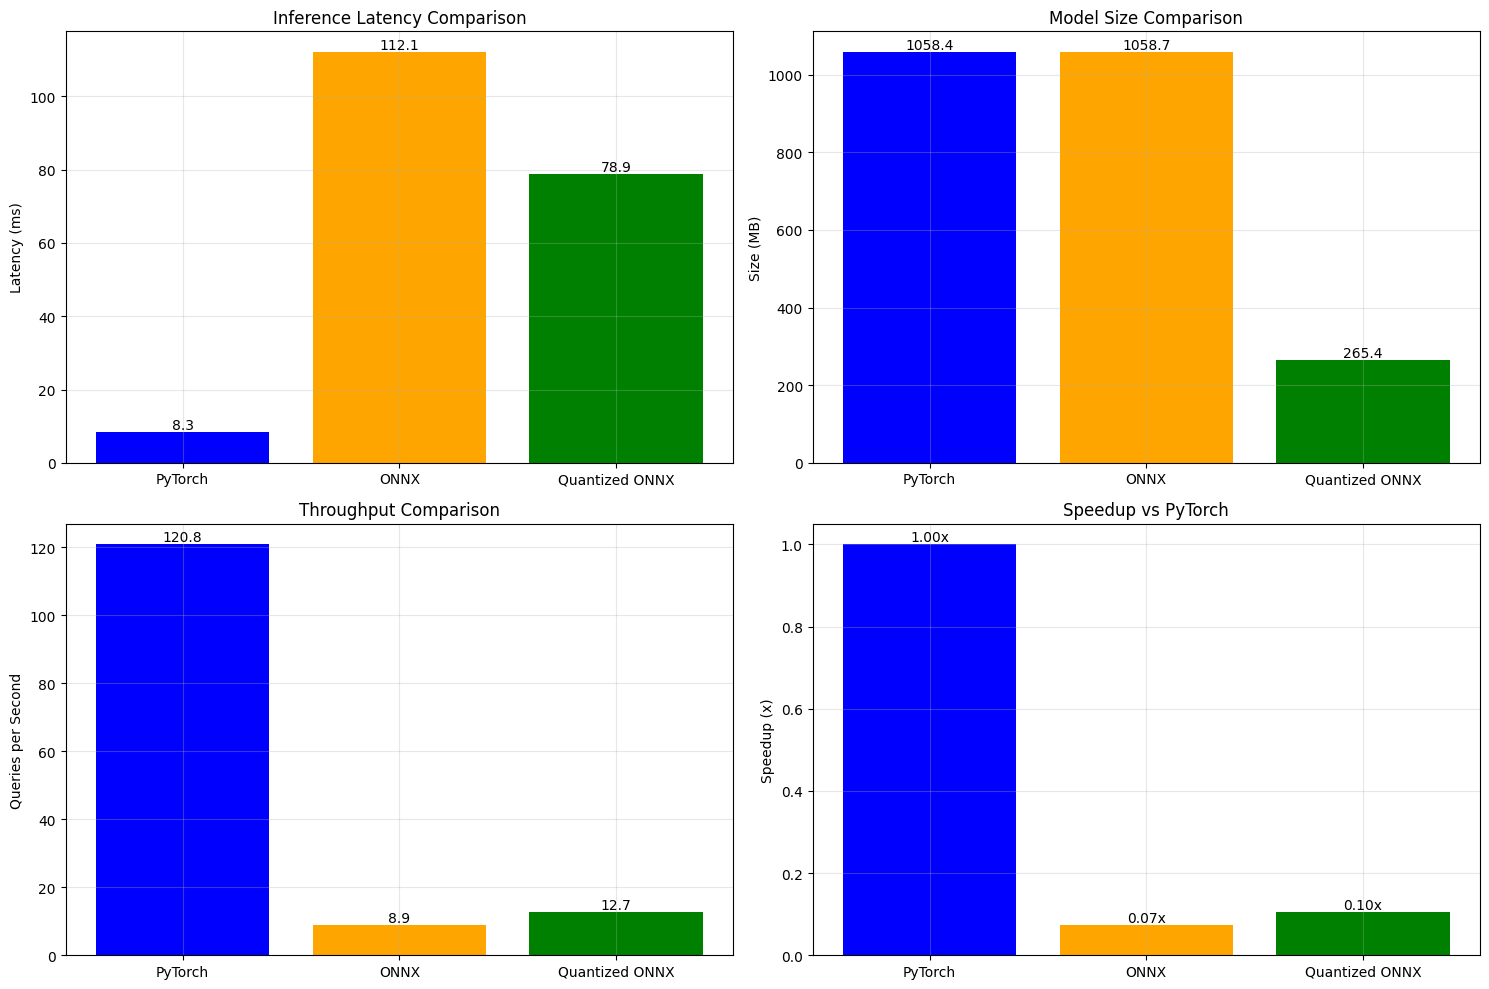


Optimization Summary Table:
--------------------------------------------------------------------------------
         Model   Size (MB)  Latency (ms)  Throughput (QPS)  Speedup  Accuracy
       PyTorch 1058.419949      8.274908        120.847264 1.000000  0.887352
          ONNX 1058.679348    112.149773          8.916648 0.073784  0.887352
Quantized ONNX  265.409415     78.896992         12.674754 0.104882  0.899209
--------------------------------------------------------------------------------


In [143]:
# Cell 15: Create visualization
def create_optimization_visualization(results, config):
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Prepare data
    models = ['PyTorch', 'ONNX', 'Quantized ONNX']
    latencies = [
        results['benchmark']['pytorch']['avg_latency_ms'],
        results['benchmark']['onnx']['avg_latency_ms'],
        results['benchmark']['quantized']['avg_latency_ms']
    ]
    sizes = [
        results['benchmark']['pytorch']['model_size_mb'],
        results['benchmark']['onnx']['model_size_mb'],
        results['benchmark']['quantized']['model_size_mb']
    ]
    throughput = [
        results['benchmark']['pytorch']['throughput_qps'],
        results['benchmark']['onnx']['throughput_qps'],
        results['benchmark']['quantized']['throughput_qps']
    ]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Latency comparison
    axes[0, 0].bar(models, latencies, color=['blue', 'orange', 'green'])
    axes[0, 0].set_title('Inference Latency Comparison')
    axes[0, 0].set_ylabel('Latency (ms)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add values on bars
    for i, v in enumerate(latencies):
        axes[0, 0].text(i, v, f'{v:.1f}', ha='center', va='bottom')
    
    # Plot 2: Model size comparison
    axes[0, 1].bar(models, sizes, color=['blue', 'orange', 'green'])
    axes[0, 1].set_title('Model Size Comparison')
    axes[0, 1].set_ylabel('Size (MB)')
    axes[0, 1].grid(True, alpha=0.3)
    
    for i, v in enumerate(sizes):
        axes[0, 1].text(i, v, f'{v:.1f}', ha='center', va='bottom')
    
    # Plot 3: Throughput comparison
    axes[1, 0].bar(models, throughput, color=['blue', 'orange', 'green'])
    axes[1, 0].set_title('Throughput Comparison')
    axes[1, 0].set_ylabel('Queries per Second')
    axes[1, 0].grid(True, alpha=0.3)
    
    for i, v in enumerate(throughput):
        axes[1, 0].text(i, v, f'{v:.1f}', ha='center', va='bottom')
    
    # Plot 4: Speedup comparison
    speedup = [1, latencies[0]/latencies[1], latencies[0]/latencies[2]]
    axes[1, 1].bar(models, speedup, color=['blue', 'orange', 'green'])
    axes[1, 1].set_title('Speedup vs PyTorch')
    axes[1, 1].set_ylabel('Speedup (x)')
    axes[1, 1].grid(True, alpha=0.3)
    
    for i, v in enumerate(speedup):
        axes[1, 1].text(i, v, f'{v:.2f}x', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, "optimization_comparison.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Create summary table
    summary_df = pd.DataFrame({
        'Model': models,
        'Size (MB)': sizes,
        'Latency (ms)': latencies,
        'Throughput (QPS)': throughput,
        'Speedup': speedup,
        'Accuracy': [
            results['accuracy']['original_accuracy'],
            results['accuracy']['onnx_accuracy'],
            results['accuracy']['quantized_accuracy']
        ]
    })
    
    print("\nOptimization Summary Table:")
    print("-"*80)
    print(summary_df.to_string(index=False))
    print("-"*80)
    
    # Save table
    summary_df.to_csv(os.path.join(config.OUTPUT_DIR, "optimization_summary.csv"), index=False)
    
    return fig, summary_df

fig, summary_df = create_optimization_visualization(final_results, config)

In [144]:
# Cell 16: Test inference with quantized model
def test_quantized_inference(session, tokenizer, text):
    """Test inference with quantized model"""
    print(f"\nTesting quantized model inference:")
    print(f"Text: {text}")
    
    tokens = text.split()
    
    # Prepare inputs
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="np",  # Use numpy for ONNX
        truncation=True,
        max_length=config.MAX_LENGTH,
        padding="max_length"
    )
    
    ort_inputs = {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    }
    
    # Run inference
    start_time = time.time()
    outputs = session.run(None, ort_inputs)
    inference_time = (time.time() - start_time) * 1000  # ms
    
    predictions = np.argmax(outputs[0], axis=-1)[0]
    
    # Extract entities
    word_ids = inputs.word_ids(batch_index=0)
    previous_word_idx = None
    predictions_aligned = []
    
    for idx, word_idx in enumerate(word_ids):
        if word_idx is not None and word_idx != previous_word_idx:
            predictions_aligned.append(predictions[idx])
        previous_word_idx = word_idx
    
    # Format output
    entities = []
    current_entity = None
    current_start = None
    current_label = None
    
    for i, (token, pred_idx) in enumerate(zip(tokens, predictions_aligned)):
        label = config.LABEL_NAMES[pred_idx]
        
        if label.startswith("B-"):
            if current_entity:
                entities.append({
                    "entity": " ".join(tokens[current_start:i]),
                    "label": current_label,
                    "start": current_start,
                    "end": i,
                    "score": 1.0  # Placeholder
                })
            current_label = label[2:]
            current_start = i
            current_entity = [token]
        elif label.startswith("I-") and current_label == label[2:]:
            current_entity.append(token)
        elif current_entity:
            entities.append({
                "entity": " ".join(current_entity),
                "label": current_label,
                "start": current_start,
                "end": i,
                "score": 1.0
            })
            current_entity = None
            current_label = None
            current_start = None
    
    if current_entity:
        entities.append({
            "entity": " ".join(current_entity),
            "label": current_label,
            "start": current_start,
            "end": len(tokens),
            "score": 1.0
        })
    
    print(f"Inference time: {inference_time:.2f} ms")
    print(f"Entities found: {entities}")
    
    return entities, inference_time

# Test with multiple languages
test_texts = [
    ("English", "Apple was founded by Steve Jobs in Cupertino."),
    ("German", "Berlin ist die Hauptstadt von Deutschland."),
    ("French", "Paris est la capitale de la France."),
    ("Spanish", "Google es una empresa de tecnología con sede en Mountain View.")
]

for lang, text in test_texts:
    print(f"\n[{lang}]")
    entities, inference_time = test_quantized_inference(quantized_session, tokenizer, text)



[English]

Testing quantized model inference:
Text: Apple was founded by Steve Jobs in Cupertino.
Inference time: 135.15 ms
Entities found: [{'entity': 'Steve Jobs', 'label': 'PER', 'start': 4, 'end': 6, 'score': 1.0}, {'entity': 'Cupertino.', 'label': 'LOC', 'start': 7, 'end': 8, 'score': 1.0}]

[German]

Testing quantized model inference:
Text: Berlin ist die Hauptstadt von Deutschland.
Inference time: 132.09 ms
Entities found: [{'entity': 'Berlin', 'label': 'LOC', 'start': 0, 'end': 1, 'score': 1.0}, {'entity': 'Deutschland.', 'label': 'LOC', 'start': 5, 'end': 6, 'score': 1.0}]

[French]

Testing quantized model inference:
Text: Paris est la capitale de la France.
Inference time: 104.21 ms
Entities found: [{'entity': 'Paris', 'label': 'LOC', 'start': 0, 'end': 1, 'score': 1.0}]

[Spanish]

Testing quantized model inference:
Text: Google es una empresa de tecnología con sede en Mountain View.
Inference time: 100.54 ms
Entities found: [{'entity': 'Google', 'label': 'ORG', 'start': 0

In [145]:
# Cell 17: Create deployment artifacts
def create_deployment_artifacts(config, tokenizer, quantized_session):
    """Create artifacts needed for deployment"""
    artifacts_dir = os.path.join(config.OUTPUT_DIR, "deployment")
    os.makedirs(artifacts_dir, exist_ok=True)
    
    # 1. Save tokenizer
    tokenizer.save_pretrained(artifacts_dir)
    
    # 2. Save model config
    model_config = {
        "model_type": "onnx_quantized",
        "max_length": config.MAX_LENGTH,
        "label_names": config.LABEL_NAMES,
        "num_labels": config.NUM_LABELS,
        "optimization_results": {
            "latency_ms": final_results['benchmark']['quantized']['avg_latency_ms'],
            "size_mb": final_results['benchmark']['quantized']['model_size_mb'],
            "accuracy": final_results['accuracy']['quantized_accuracy']
        }
    }
    
    with open(os.path.join(artifacts_dir, "config.json"), "w") as f:
        json.dump(model_config, f, indent=2)
    
    # 3. Copy quantized model
    import shutil
    shutil.copy2(
        quantized_path,
        os.path.join(artifacts_dir, "model.onnx")
    )
    
    # 4. Create requirements file
    requirements = [
        "onnxruntime>=1.15.0",
        "transformers>=4.30.0",
        "tokenizers>=0.13.0",
        "numpy>=1.24.0"
    ]
    
    with open(os.path.join(artifacts_dir, "requirements.txt"), "w") as f:
        f.write("\n".join(requirements))
    
    # 5. Create inference script template
    inference_template = '''import onnxruntime as ort
import numpy as np
from transformers import AutoTokenizer
import json

class MultilingualNER:
    def __init__(self, model_path, tokenizer_path):
        self.session = ort.InferenceSession(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
        
        with open(f"{tokenizer_path}/config.json", "r") as f:
            self.config = json.load(f)
    
    def predict(self, text, language="en"):
        # Implementation here
        pass

if __name__ == "__main__":
    # Example usage
    model = MultilingualNER("model.onnx", ".")
    result = model.predict("Apple is in Cupertino.")
    print(result)
'''
    
    with open(os.path.join(artifacts_dir, "inference_example.py"), "w") as f:
        f.write(inference_template)
    
    print(f"\nDeployment artifacts created in {artifacts_dir}")
    print("Contents:")
    for item in os.listdir(artifacts_dir):
        print(f"  - {item}")

create_deployment_artifacts(config, tokenizer, quantized_session)

print("\n" + "="*60)
print("OPTIMIZATION COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Final quantized model: {final_results['benchmark']['quantized']['model_size_mb']:.1f} MB")
print(f"Inference latency: {final_results['benchmark']['quantized']['avg_latency_ms']:.1f} ms")
print(f"Throughput: {final_results['benchmark']['quantized']['throughput_qps']:.1f} QPS")
print(f"Accuracy: {final_results['accuracy']['quantized_accuracy']:.4f}")


Deployment artifacts created in ./models/optimized/deployment
Contents:
  - config.json
  - special_tokens_map.json
  - tokenizer.json
  - requirements.txt
  - tokenizer_config.json
  - model.onnx
  - inference_example.py
  - sentencepiece.bpe.model

OPTIMIZATION COMPLETED SUCCESSFULLY!
Final quantized model: 265.4 MB
Inference latency: 78.9 ms
Throughput: 12.7 QPS
Accuracy: 0.8992


# notebooks/06_error_analysis.ipynb

In [146]:
# Cell 1: Setup and imports
!pip install transformers datasets evaluate seqeval
!pip install pandas numpy matplotlib seaborn
!pip install scikit-learn

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.metrics import classification_report, confusion_matrix
import json
import os
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [147]:
# Cell 2: Configuration
class ErrorAnalysisConfig:
    MODEL_PATH = "./models/student_distilled"  # Or your quantized model
    DATASET_NAME = "wikiann"
    LANGUAGES = ["en", "de", "fr", "es", "ru"]  # Multiple languages for analysis
    MAX_LENGTH = 128
    SAMPLE_SIZE = 500  # Samples per language for analysis
    LABEL_NAMES = [
        "O",
        "B-PER", "I-PER",
        "B-ORG", "I-ORG",
        "B-LOC", "I-LOC"
    ]
    OUTPUT_DIR = "./analysis"

config = ErrorAnalysisConfig()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

In [148]:
# Cell 3: Load model and tokenizer
print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_PATH)

try:
    model = AutoModelForTokenClassification.from_pretrained(config.MODEL_PATH)
    model_type = "PyTorch"
except:
    # Try loading ONNX model
    import onnxruntime as ort
    model = ort.InferenceSession(os.path.join(config.MODEL_PATH, "model.onnx"))
    model_type = "ONNX"
    print("Loaded ONNX model")

print(f"Model type: {model_type}")

Loading model and tokenizer...
Model type: PyTorch


In [149]:
# Cell 4: Load test data
def load_test_data(languages, sample_size=500):
    """Load test data for multiple languages"""
    all_data = []
    
    for lang in languages:
        try:
            print(f"Loading {lang} test data...")
            dataset = load_dataset(config.DATASET_NAME, lang)
            test_data = dataset['test']
            
            # Sample if needed
            if sample_size < len(test_data):
                indices = np.random.choice(len(test_data), sample_size, replace=False)
                test_data = test_data.select(indices)
            
            # Add language tag
            test_data = test_data.add_column("language", [lang] * len(test_data))
            all_data.append(test_data)
            
        except Exception as e:
            print(f"Failed to load {lang}: {e}")
    
    # Combine all data
    from datasets import concatenate_datasets
    combined_data = concatenate_datasets(all_data) if all_data else None
    
    print(f"Total test samples: {len(combined_data)}")
    return combined_data

test_data = load_test_data(config.LANGUAGES, config.SAMPLE_SIZE)

Loading en test data...


Flattening the indices:   0%|          | 0/500 [00:00<?, ? examples/s]

Loading de test data...


Flattening the indices:   0%|          | 0/500 [00:00<?, ? examples/s]

Loading fr test data...


Flattening the indices:   0%|          | 0/500 [00:00<?, ? examples/s]

Loading es test data...


es/validation-00000-of-00001.parquet:   0%|          | 0.00/608k [00:00<?, ?B/s]

es/test-00000-of-00001.parquet:   0%|          | 0.00/608k [00:00<?, ?B/s]

es/train-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/500 [00:00<?, ? examples/s]

Loading ru test data...


ru/validation-00000-of-00001.parquet:   0%|          | 0.00/809k [00:00<?, ?B/s]

ru/test-00000-of-00001.parquet:   0%|          | 0.00/816k [00:00<?, ?B/s]

ru/train-00000-of-00001.parquet:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/500 [00:00<?, ? examples/s]

Total test samples: 2500


In [150]:
# Cell 5: Prediction function
def predict_entities(model, tokenizer, tokens, model_type="PyTorch"):
    """Predict entities for a tokenized sentence"""
    # Tokenize
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt" if model_type == "PyTorch" else "np",
        truncation=True,
        max_length=config.MAX_LENGTH,
        padding="max_length"
    )
    
    if model_type == "PyTorch":
        with torch.no_grad():
            outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)[0].cpu().numpy()
    else:
        # ONNX model
        ort_inputs = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']
        }
        outputs = model.run(None, ort_inputs)
        predictions = np.argmax(outputs[0], axis=-1)[0]
    
    # Align predictions with original tokens
    word_ids = inputs.word_ids(batch_index=0)
    aligned_predictions = []
    
    previous_word_idx = None
    for idx, word_idx in enumerate(word_ids):
        if word_idx is not None and word_idx != previous_word_idx:
            aligned_predictions.append(predictions[idx])
        previous_word_idx = word_idx
    
    # Ensure length matches
    if len(aligned_predictions) > len(tokens):
        aligned_predictions = aligned_predictions[:len(tokens)]
    elif len(aligned_predictions) < len(tokens):
        aligned_predictions.extend([0] * (len(tokens) - len(aligned_predictions)))
    
    return aligned_predictions

In [151]:
# Cell 6: Run predictions on test data
def collect_predictions(model, tokenizer, test_data, model_type="PyTorch", max_samples=1000):
    """Collect predictions for error analysis"""
    predictions_data = []
    
    for i, sample in enumerate(test_data):
        if i >= max_samples:
            break
            
        tokens = sample['tokens']
        true_labels = sample['ner_tags']
        language = sample['language']
        
        # Get predictions
        try:
            pred_labels = predict_entities(model, tokenizer, tokens, model_type)
            
            # Store results
            predictions_data.append({
                'id': i,
                'language': language,
                'tokens': tokens,
                'true_labels': true_labels,
                'pred_labels': pred_labels,
                'text': ' '.join(tokens[:50]) + ('...' if len(tokens) > 50 else ''),
                'length': len(tokens)
            })
            
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue
    
    return pd.DataFrame(predictions_data)

print("Collecting predictions...")
df_predictions = collect_predictions(model, tokenizer, test_data, model_type, max_samples=1000)
print(f"Collected {len(df_predictions)} predictions")

Collected 1000 predictions


In [152]:
# Cell 7: Calculate overall metrics
def calculate_overall_metrics(df):
    """Calculate overall performance metrics"""
    all_true = []
    all_pred = []
    
    for _, row in df.iterrows():
        true = row['true_labels']
        pred = row['pred_labels']
        
        # Align lengths
        min_len = min(len(true), len(pred))
        all_true.extend(true[:min_len])
        all_pred.extend(pred[:min_len])
    
    # Convert to label names
    true_labels = [config.LABEL_NAMES[t] for t in all_true]
    pred_labels = [config.LABEL_NAMES[p] for p in all_pred]
    
    # Classification report
    from evaluate import load
    seqeval = load("seqeval")
    
    # Prepare sequences
    true_sequences = [[config.LABEL_NAMES[l] for l in row['true_labels']] for _, row in df.iterrows()]
    pred_sequences = [[config.LABEL_NAMES[l] for l in row['pred_labels'][:len(row['true_labels'])]] 
                      for _, row in df.iterrows()]
    
    results = seqeval.compute(
        predictions=pred_sequences,
        references=true_sequences
    )
    
    return results, true_labels, pred_labels

overall_results, true_labels, pred_labels = calculate_overall_metrics(df_predictions)

print("\n" + "="*60)
print("OVERALL PERFORMANCE")
print("="*60)
print(f"Precision: {overall_results['overall_precision']:.4f}")
print(f"Recall:    {overall_results['overall_recall']:.4f}")
print(f"F1 Score:  {overall_results['overall_f1']:.4f}")
print(f"Accuracy:  {overall_results['overall_accuracy']:.4f}")



OVERALL PERFORMANCE
Precision: 0.8028
Recall:    0.8213
F1 Score:  0.8120
Accuracy:  0.9357


In [153]:
# Cell 8: Per-language analysis
def analyze_by_language(df):
    """Analyze performance by language"""
    language_results = {}
    
    for lang in df['language'].unique():
        lang_df = df[df['language'] == lang]
        
        all_true = []
        all_pred = []
        
        for _, row in lang_df.iterrows():
            true = row['true_labels']
            pred = row['pred_labels']
            
            min_len = min(len(true), len(pred))
            all_true.extend(true[:min_len])
            all_pred.extend(pred[:min_len])
        
        # Calculate metrics
        from sklearn.metrics import precision_recall_fscore_support
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_true, all_pred, average='weighted', zero_division=0
        )
        
        language_results[lang] = {
            'samples': len(lang_df),
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': sum(t == p for t, p in zip(all_true, all_pred)) / len(all_true) if all_true else 0
        }
    
    return pd.DataFrame(language_results).T

language_df = analyze_by_language(df_predictions)
print("\n" + "="*60)
print("PER-LANGUAGE PERFORMANCE")
print("="*60)
print(language_df.to_string())



PER-LANGUAGE PERFORMANCE
    samples  precision    recall        f1  accuracy
en    500.0   0.903970  0.903586  0.903468  0.903586
de    500.0   0.960016  0.959860  0.959815  0.959860


In [154]:
# Cell 9: Per-entity type analysis
def analyze_by_entity(df):
    """Analyze performance by entity type"""
    entity_results = defaultdict(lambda: {'true': 0, 'pred': 0, 'correct': 0})
    
    for _, row in df.iterrows():
        true = row['true_labels']
        pred = row['pred_labels']
        
        min_len = min(len(true), len(pred))
        
        for i in range(min_len):
            true_label = config.LABEL_NAMES[true[i]]
            pred_label = config.LABEL_NAMES[pred[i]]
            
            # Skip 'O' labels for entity analysis
            if true_label != 'O':
                entity_type = true_label[2:] if '-' in true_label else true_label
                entity_results[entity_type]['true'] += 1
                
                if pred_label != 'O':
                    pred_type = pred_label[2:] if '-' in pred_label else pred_label
                    entity_results[pred_type]['pred'] += 1
                    
                    if true_label == pred_label:
                        entity_results[entity_type]['correct'] += 1
    
    # Calculate metrics
    entity_metrics = {}
    for entity_type, counts in entity_results.items():
        precision = counts['correct'] / counts['pred'] if counts['pred'] > 0 else 0
        recall = counts['correct'] / counts['true'] if counts['true'] > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        entity_metrics[entity_type] = {
            'true_count': counts['true'],
            'pred_count': counts['pred'],
            'correct_count': counts['correct'],
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    return pd.DataFrame(entity_metrics).T

entity_df = analyze_by_entity(df_predictions)
print("\n" + "="*60)
print("PER-ENTITY TYPE PERFORMANCE")
print("="*60)
print(entity_df.to_string())



PER-ENTITY TYPE PERFORMANCE
     true_count  pred_count  correct_count  precision    recall        f1
PER      1231.0      1176.0         1090.0   0.926871  0.885459  0.905692
ORG      1393.0      1324.0         1134.0   0.856495  0.814070  0.834744
LOC       911.0       950.0          807.0   0.849474  0.885840  0.867276


Generating confusion matrix...


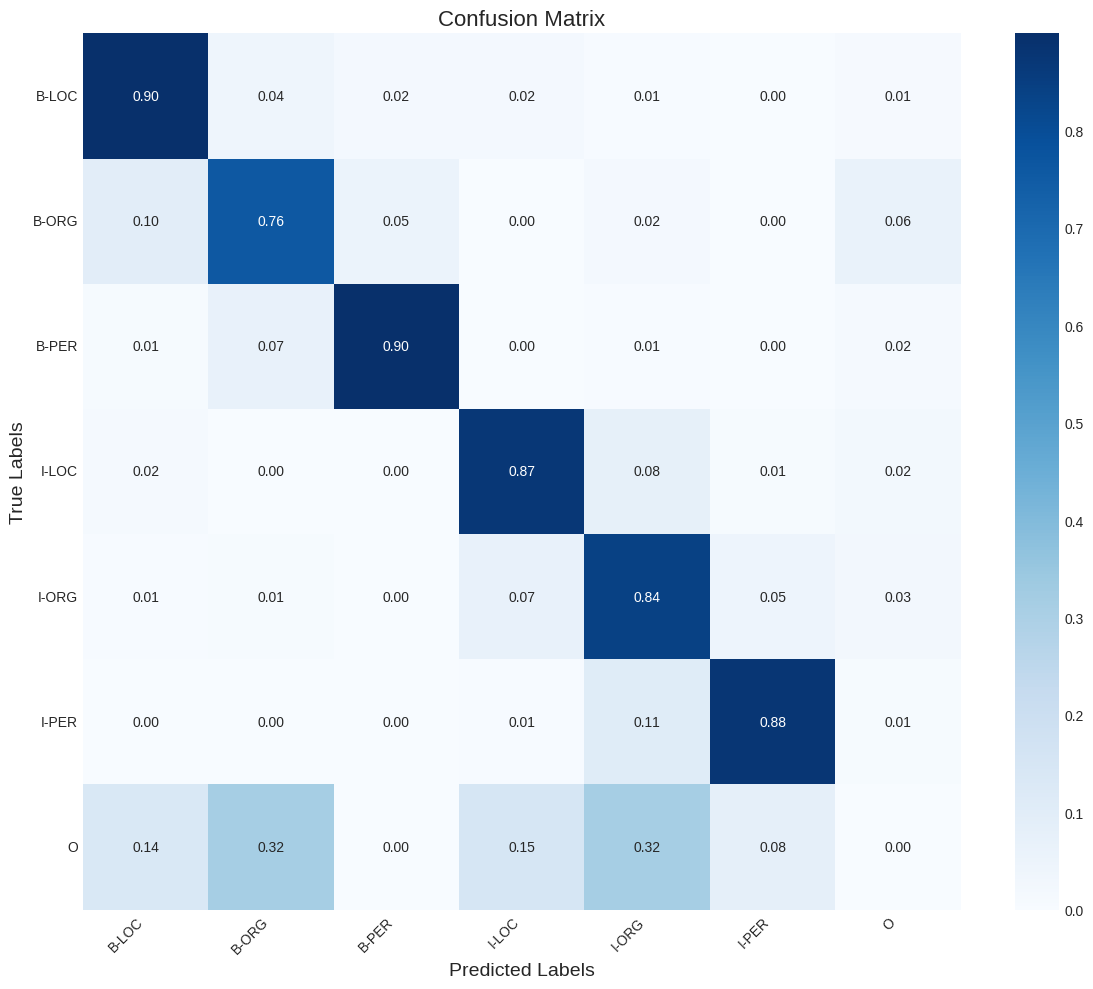

In [155]:
# Cell 10: Confusion matrix
def plot_confusion_matrix(true_labels, pred_labels, title="Confusion Matrix"):
    """Plot normalized confusion matrix"""
    # Filter out 'O' labels for clearer visualization
    filtered_true = []
    filtered_pred = []
    
    for t, p in zip(true_labels, pred_labels):
        if t != 'O' or p != 'O':
            filtered_true.append(t)
            filtered_pred.append(p)
    
    # Get unique labels (excluding 'O' if desired)
    unique_labels = sorted(set(filtered_true + filtered_pred))
    
    # Calculate confusion matrix
    cm = confusion_matrix(filtered_true, filtered_pred, labels=unique_labels)
    
    # Normalize
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=unique_labels, yticklabels=unique_labels)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, "confusion_matrix.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    return cm, cm_normalized

print("Generating confusion matrix...")
cm, cm_norm = plot_confusion_matrix(true_labels, pred_labels)

In [156]:
# Cell 11: Error patterns analysis
def analyze_error_patterns(df):
    """Analyze common error patterns"""
    error_patterns = []
    
    for _, row in df.iterrows():
        tokens = row['tokens']
        true = row['true_labels']
        pred = row['pred_labels']
        
        min_len = min(len(tokens), len(true), len(pred))
        
        i = 0
        while i < min_len:
            true_label = config.LABEL_NAMES[true[i]]
            pred_label = config.LABEL_NAMES[pred[i]]
            
            if true_label != pred_label:
                # Find error span
                start = i
                error_type = f"{true_label}->{pred_label}"
                
                # Check if it's a span error
                while i < min_len and config.LABEL_NAMES[true[i]] != config.LABEL_NAMES[pred[i]]:
                    i += 1
                
                end = i
                error_span = ' '.join(tokens[start:end])
                
                error_patterns.append({
                    'pattern': error_type,
                    'span': error_span,
                    'length': end - start,
                    'language': row['language'],
                    'true_label': true_label,
                    'pred_label': pred_label
                })
            else:
                i += 1
    
    return pd.DataFrame(error_patterns)

error_df = analyze_error_patterns(df_predictions)

print("\n" + "="*60)
print("TOP ERROR PATTERNS")
print("="*60)
top_errors = error_df['pattern'].value_counts().head(10)
print(top_errors)



TOP ERROR PATTERNS
pattern
B-ORG->B-LOC    44
B-PER->B-ORG    32
B-ORG->O        29
B-ORG->B-PER    25
O->B-ORG        23
B-LOC->B-ORG    19
O->I-ORG        12
O->B-LOC        10
B-LOC->B-PER     9
B-PER->O         8
Name: count, dtype: int64


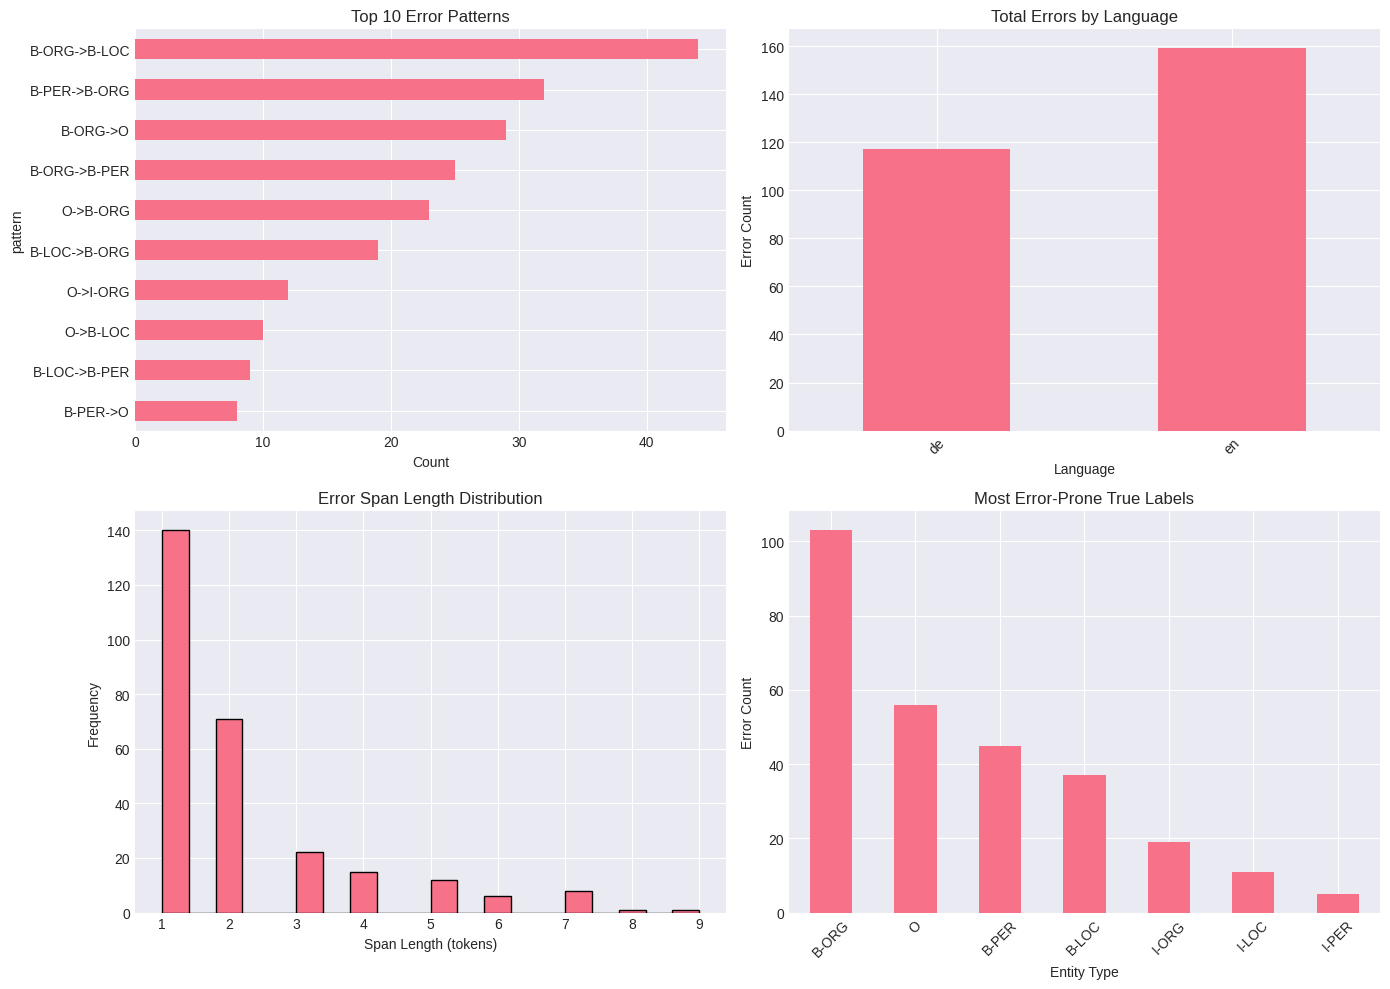

In [157]:
# Cell 12: Visualize error patterns
def visualize_error_patterns(error_df):
    """Create visualizations for error patterns"""
    
    # 1. Most common error patterns
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    top_patterns = error_df['pattern'].value_counts().head(10)
    top_patterns.plot(kind='barh')
    plt.title('Top 10 Error Patterns')
    plt.xlabel('Count')
    plt.gca().invert_yaxis()
    
    # 2. Error patterns by language
    plt.subplot(2, 2, 2)
    errors_by_lang = error_df.groupby('language')['pattern'].count()
    errors_by_lang.plot(kind='bar')
    plt.title('Total Errors by Language')
    plt.xlabel('Language')
    plt.ylabel('Error Count')
    plt.xticks(rotation=45)
    
    # 3. Error length distribution
    plt.subplot(2, 2, 3)
    error_df['length'].plot(kind='hist', bins=20, edgecolor='black')
    plt.title('Error Span Length Distribution')
    plt.xlabel('Span Length (tokens)')
    plt.ylabel('Frequency')
    
    # 4. Error types by entity
    plt.subplot(2, 2, 4)
    error_df['true_label'].value_counts().head(10).plot(kind='bar')
    plt.title('Most Error-Prone True Labels')
    plt.xlabel('Entity Type')
    plt.ylabel('Error Count')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, "error_patterns.png"), dpi=150, bbox_inches='tight')
    plt.show()

visualize_error_patterns(error_df)


In [158]:
# Cell 13: Hard examples analysis
def find_hard_examples(df, n_examples=10):
    """Find the most challenging examples"""
    example_scores = []
    
    for idx, row in df.iterrows():
        true = row['true_labels']
        pred = row['pred_labels']
        
        min_len = min(len(true), len(pred))
        correct = sum(1 for t, p in zip(true[:min_len], pred[:min_len]) if t == p)
        accuracy = correct / min_len if min_len > 0 else 0
        
        example_scores.append({
            'id': idx,
            'language': row['language'],
            'text': row['text'][:100],
            'accuracy': accuracy,
            'length': row['length'],
            'tokens': row['tokens'],
            'true_labels': row['true_labels'],
            'pred_labels': row['pred_labels']
        })
    
    # Sort by accuracy (lowest first)
    example_scores.sort(key=lambda x: x['accuracy'])
    
    return example_scores[:n_examples]

hard_examples = find_hard_examples(df_predictions, n_examples=10)

print("\n" + "="*60)
print("TOP 10 HARDEST EXAMPLES")
print("="*60)

for i, example in enumerate(hard_examples, 1):
    print(f"\nExample {i} ({example['language']}, Accuracy: {example['accuracy']:.2f}):")
    print(f"Text: {example['text']}")
    
    # Show errors
    tokens = example['tokens'][:20]  # First 20 tokens
    true = example['true_labels'][:20]
    pred = example['pred_labels'][:20]
    
    for j, (token, t, p) in enumerate(zip(tokens, true, pred)):
        t_label = config.LABEL_NAMES[t]
        p_label = config.LABEL_NAMES[p]
        
        if t_label != p_label:
            print(f"  ERROR: '{token}' - True: {t_label}, Pred: {p_label}")
        elif t_label != 'O':
            print(f"  CORRECT: '{token}' - {t_label}")


TOP 10 HARDEST EXAMPLES

Example 1 (en, Accuracy: 0.00):
Text: Lucky 7 ( album )
  ERROR: 'Lucky' - True: B-LOC, Pred: B-ORG
  ERROR: '7' - True: I-LOC, Pred: I-ORG
  ERROR: '(' - True: I-LOC, Pred: I-ORG
  ERROR: 'album' - True: I-LOC, Pred: I-ORG
  ERROR: ')' - True: I-LOC, Pred: I-ORG

Example 2 (en, Accuracy: 0.00):
Text: Northern Tioga School District
  ERROR: 'Northern' - True: B-ORG, Pred: B-LOC
  ERROR: 'Tioga' - True: I-ORG, Pred: I-LOC
  ERROR: 'School' - True: I-ORG, Pred: I-LOC
  ERROR: 'District' - True: I-ORG, Pred: I-LOC

Example 3 (en, Accuracy: 0.00):
Text: Wheatland Hop Riot of 1913
  ERROR: 'Wheatland' - True: B-PER, Pred: B-ORG
  ERROR: 'Hop' - True: I-PER, Pred: I-ORG
  ERROR: 'Riot' - True: I-PER, Pred: I-ORG
  ERROR: 'of' - True: I-PER, Pred: I-ORG
  ERROR: '1913' - True: I-PER, Pred: I-ORG

Example 4 (en, Accuracy: 0.00):
Text: Party leaders of the United States Senate
  ERROR: 'Party' - True: B-PER, Pred: B-ORG
  ERROR: 'leaders' - True: I-PER, Pred: I-ORG
  E

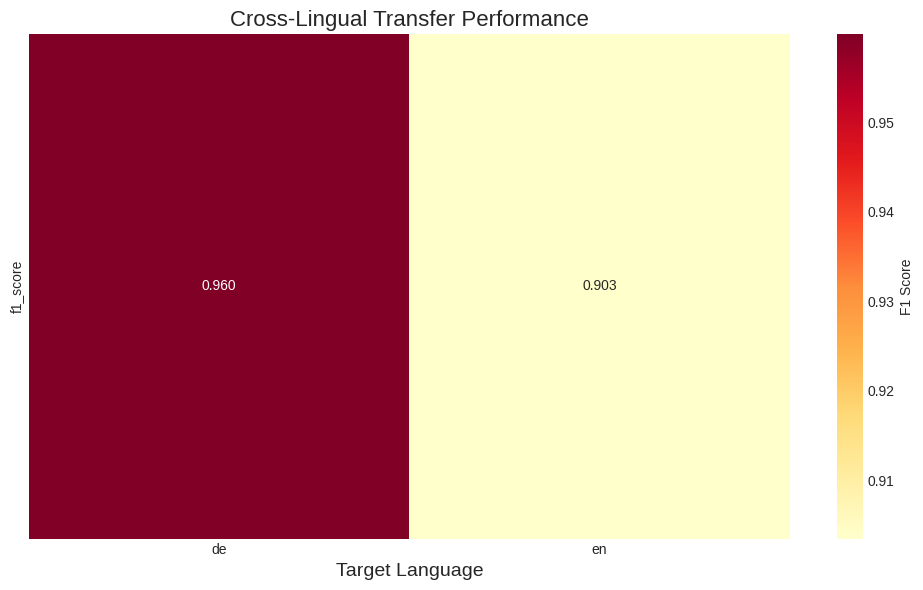

In [159]:
# Cell 14: Cross-lingual transfer analysis
def analyze_cross_lingual_transfer(df):
    """Analyze how well the model transfers across languages"""
    transfer_matrix = {}
    
    languages = sorted(df['language'].unique())
    
    for lang in languages:
        lang_df = df[df['language'] == lang]
        
        # Calculate metrics for this language when trained on all languages
        all_true = []
        all_pred = []
        
        for _, row in lang_df.iterrows():
            true = row['true_labels']
            pred = row['pred_labels']
            
            min_len = min(len(true), len(pred))
            all_true.extend(true[:min_len])
            all_pred.extend(pred[:min_len])
        
        # Calculate F1
        from sklearn.metrics import f1_score
        f1 = f1_score(all_true, all_pred, average='weighted')
        
        transfer_matrix[lang] = {
            'samples': len(lang_df),
            'f1_score': f1
        }
    
    # Create heatmap
    transfer_df = pd.DataFrame(transfer_matrix).T
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(transfer_df[['f1_score']].T, annot=True, fmt='.3f', cmap='YlOrRd',
                cbar_kws={'label': 'F1 Score'})
    
    plt.title('Cross-Lingual Transfer Performance', fontsize=16)
    plt.xlabel('Target Language', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, "cross_lingual_transfer.png"), 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    return transfer_df

transfer_df = analyze_cross_lingual_transfer(df_predictions)




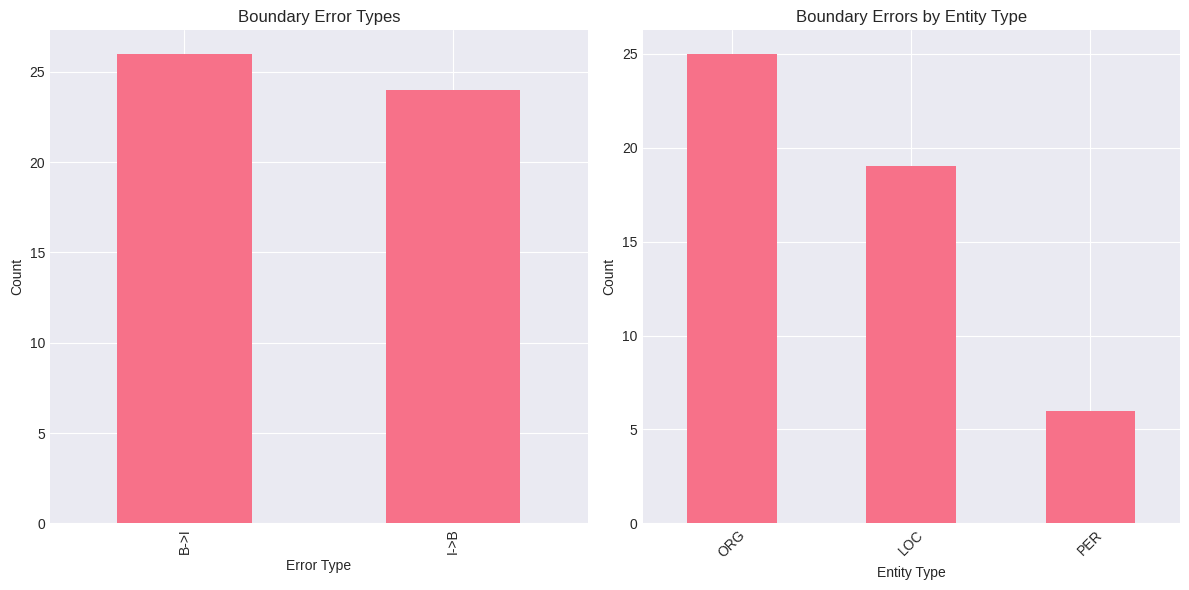


Boundary Errors Summary:
type
B->I    26
I->B    24
Name: count, dtype: int64


In [160]:
# Cell 15: Boundary errors analysis
def analyze_boundary_errors(df):
    """Analyze boundary detection errors (B-I confusion)"""
    boundary_errors = []
    
    for _, row in df.iterrows():
        tokens = row['tokens']
        true = row['true_labels']
        pred = row['pred_labels']
        
        min_len = min(len(tokens), len(true), len(pred))
        
        i = 0
        while i < min_len:
            true_label = config.LABEL_NAMES[true[i]]
            pred_label = config.LABEL_NAMES[pred[i]]
            
            # Check for boundary errors
            if true_label.startswith('B-') and pred_label.startswith('I-'):
                # Boundary missed (B->I)
                entity_type = true_label[2:]
                boundary_errors.append({
                    'type': 'B->I',
                    'entity': entity_type,
                    'token': tokens[i],
                    'language': row['language']
                })
            elif true_label.startswith('I-') and pred_label.startswith('B-'):
                # Boundary inserted (I->B)
                entity_type = true_label[2:]
                boundary_errors.append({
                    'type': 'I->B',
                    'entity': entity_type,
                    'token': tokens[i],
                    'language': row['language']
                })
            
            i += 1
    
    boundary_df = pd.DataFrame(boundary_errors)
    
    if len(boundary_df) > 0:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        boundary_df['type'].value_counts().plot(kind='bar')
        plt.title('Boundary Error Types')
        plt.xlabel('Error Type')
        plt.ylabel('Count')
        
        plt.subplot(1, 2, 2)
        boundary_df['entity'].value_counts().head(10).plot(kind='bar')
        plt.title('Boundary Errors by Entity Type')
        plt.xlabel('Entity Type')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig(os.path.join(config.OUTPUT_DIR, "boundary_errors.png"), 
                    dpi=150, bbox_inches='tight')
        plt.show()
    
    return boundary_df

boundary_df = analyze_boundary_errors(df_predictions)
if len(boundary_df) > 0:
    print("\nBoundary Errors Summary:")
    print(boundary_df['type'].value_counts())


In [161]:
# Cell 16: Create comprehensive error report
def create_error_report(df, error_df, entity_df, language_df, transfer_df, config):
    """Create comprehensive error analysis report"""
    
    report = {
        'summary': {
            'total_samples': len(df),
            'languages_analyzed': list(df['language'].unique()),
            'overall_f1': overall_results['overall_f1'],
            'overall_precision': overall_results['overall_precision'],
            'overall_recall': overall_results['overall_recall']
        },
        'per_language': language_df.to_dict('index'),
        'per_entity': entity_df.to_dict('index'),
        'error_patterns': {
            'total_errors': len(error_df),
            'top_patterns': error_df['pattern'].value_counts().head(10).to_dict(),
            'errors_by_language': error_df['language'].value_counts().to_dict()
        },
        'cross_lingual': transfer_df.to_dict('index'),
        'hard_examples': [
            {
                'id': ex['id'],
                'language': ex['language'],
                'accuracy': ex['accuracy'],
                'text_preview': ex['text'][:100]
            }
            for ex in find_hard_examples(df, n_examples=5)
        ]
    }
    
    # Save report
    report_path = os.path.join(config.OUTPUT_DIR, "error_analysis_report.json")
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)
    
    print(f"\nError analysis report saved to {report_path}")
    
    # Create markdown summary
    md_report = f"""# Multilingual NER Error Analysis Report

## Summary
- **Total Samples Analyzed**: {report['summary']['total_samples']}
- **Languages**: {', '.join(report['summary']['languages_analyzed'])}
- **Overall F1 Score**: {report['summary']['overall_f1']:.4f}
- **Overall Precision**: {report['summary']['overall_precision']:.4f}
- **Overall Recall**: {report['summary']['overall_recall']:.4f}

## Top Error Patterns
"""
    
    for pattern, count in report['error_patterns']['top_patterns'].items():
        md_report += f"- `{pattern}`: {count} occurrences\n"
    
    md_report += "\n## Recommendations\n"
    
    # Generate recommendations based on analysis
    if 'PER->ORG' in report['error_patterns']['top_patterns']:
        md_report += "- **Person vs Organization confusion**: Consider adding more diverse examples of organizations vs person names in training\n"
    
    if 'LOC->ORG' in report['error_patterns']['top_patterns']:
        md_report += "- **Location vs Organization confusion**: Location names being classified as organizations is common, especially for companies named after places\n"
    
    if any('B->I' in pattern for pattern in report['error_patterns']['top_patterns']):
        md_report += "- **Boundary detection issues**: Model struggles with entity boundaries. Consider adding more training examples with multi-word entities\n"
    
    # Language-specific recommendations
    lowest_lang = min(report['per_language'].items(), key=lambda x: x[1]['f1'])
    md_report += f"\n- **Lowest performing language**: {lowest_lang[0]} (F1: {lowest_lang[1]['f1']:.3f}). Consider adding more {lowest_lang[0]} training data\n"
    
    md_report_path = os.path.join(config.OUTPUT_DIR, "error_analysis_report.md")
    with open(md_report_path, 'w') as f:
        f.write(md_report)
    
    print(f"Markdown report saved to {md_report_path}")
    print("\n" + "="*60)
    print("ERROR ANALYSIS COMPLETE")
    print("="*60)
    
    return report

report = create_error_report(df_predictions, error_df, entity_df, language_df, transfer_df, config)

# Cell 17: Interactive visualization with Plotly
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Create interactive confusion matrix
    unique_labels = sorted(set(true_labels + pred_labels))
    cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
    
    fig = px.imshow(
        cm,
        labels=dict(x="Predicted", y="True", color="Count"),
        x=unique_labels,
        y=unique_labels,
        title="Interactive Confusion Matrix",
        color_continuous_scale='Blues'
    )
    
    fig.update_xaxes(tickangle=45)
    fig.write_html(os.path.join(config.OUTPUT_DIR, "interactive_confusion_matrix.html"))
    
    # Create interactive performance by language
    lang_fig = px.bar(
        language_df.reset_index(),
        x='index',
        y='f1',
        title='F1 Score by Language',
        labels={'index': 'Language', 'f1': 'F1 Score'},
        color='f1',
        color_continuous_scale='Viridis'
    )
    
    lang_fig.write_html(os.path.join(config.OUTPUT_DIR, "performance_by_language.html"))
    
    print("\nInteractive visualizations created:")
    print(f"  - {config.OUTPUT_DIR}/interactive_confusion_matrix.html")
    print(f"  - {config.OUTPUT_DIR}/performance_by_language.html")
    
except ImportError:
    print("Plotly not installed. Skipping interactive visualizations.")

print("\nError analysis completed successfully!")


Error analysis report saved to ./analysis/error_analysis_report.json
Markdown report saved to ./analysis/error_analysis_report.md

ERROR ANALYSIS COMPLETE

Interactive visualizations created:
  - ./analysis/interactive_confusion_matrix.html
  - ./analysis/performance_by_language.html

Error analysis completed successfully!
